In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Tue Jan 13 00:09:37 PST 2026
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@263eb3d9b80b13735a7380bb892430eaba92603a#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@14726994615ddaac5513f19155799d6debf4ecb7#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/china/2026_01_11_13_36_17/
```

Artifact:

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0
```

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 10.0 results for two locations
model_run_subdir = 'results/abie_consistent_model_test/china/2026_01_11_13_36_17/'
!ls -halt $model_run_subdir/results

total 60K
drwxrwsr-x  5 abie IHME-Simulationscience 4.5K Jan 11 18:05 ..
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 18:02 deaths
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 18:01 person_time_treatment
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:55 person_time_eligible_for_bbbm_testing
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:53 counts_baseline_tests_among_eligible
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:49 transition_count_alzheimers_disease_and_other_dementias
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:37 ylls
drwxrwsr-x  2 abie IHME-Simulationscience 1.0K Jan 11 17:36 ylds
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:30 person_time_ever_eligible_for_bbbm_testing
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:26 counts_bbbm_tests
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:24 counts_new_simulants
drwxrwsr-x  2 abie IHME-Simulationscience  512 Jan 11 17:23 person_time_alz

In [7]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
!cat $model_run_subdir/model_specification.yaml | grep -e artifact -e results

      controller: vivarium.framework.artifact.ArtifactManager
      builder_interface: vivarium.framework.artifact.ArtifactInterface
    results:
      controller: vivarium.framework.results.ResultsManager
      builder_interface: vivarium.framework.results.ResultsInterface
    results:
    artifact_path: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf
      - bbbm_test_results
    results_directory: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/china/2026_01_11_13_36_17


In [9]:
locations = [
    'United States of America',
    # 'Brazil',
    'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '10.0' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'}

In [10]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/china/2026_01_11_13_36_17/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [11]:
# # Instead of creating this dtype here, create an appropriate dtype in
# # the load_sim_output function.
# # Order locations lexicographically
# all_locations = [
#     'United States of America',
#     'Brazil',
#     'China',
#     'Germany',
#     'Israel',
#     'Japan',
#     'Spain',
#     'Sweden',
#     'Taiwan (Province of China)',
#     'United Kingdom',
# ]
# location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    # 'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [12]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [13]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [14]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [15]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [ ]:
# Create an operator object - treat each random seed as a separate draw,
# and add location to the index
ops = VPHOperator(location_col=True)
# ops.index_cols.extend(['location', 'random_seed'])

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        # NOTE: New Vivarium version stores each measure in a folder
        # instead of a single .parquet file
        parquet_file_path = Path(directory) / measure #f'{measure}.parquet'
        # The ParquetDataset object has a .schema attribute we can use
        # to get its column names and data types 
        parquet_dataset = pa.parquet.ParquetDataset(parquet_file_path)
        # # NOTE: This code no longer works with datasets stored in
        # # directories instead of single parquet files:
        # # Read the Parquet file's schema to get column names and data types
        # parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_dataset.schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_dataset.schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)
        # df = parquet_dataset.read(**kwargs).to_pandas()

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Filter seeds by monkey-patching the above data loading function

In [50]:
# Model 10.0 was run with 100 seeds instead of 5, so let's just filter
# everything to 5 seeds to make it all run faster
# seeds = [338, 6520, 3585, 7745, 539]
seeds = [7179, 2599, 1534, 386, 1935]
seed_filter = ('random_seed', 'in', seeds)

def add_filter(load_func, new_filter):
    """Return load_func, but with `new_filter` added to its list of
    parquet filters in the 'filters' key of kwargs.
    """
    def new_load_func(*args, **kwargs):
        user_filters = kwargs.get('filters') # Defaults to None
        kwargs['filters'] = add_parquet_AND_filter(
            new_filter, user_filters)
        return load_func(*args, **kwargs)
    return new_load_func

# Monkey-patch!
load_sim_output = add_filter(load_sim_output, seed_filter)

# Test code for loading sim output

In [43]:
dataset_path = Path(location_to_results_dir['all']) / 'counts_new_simulants'
dataset_path

PosixPath('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/china/2026_01_11_13_36_17/results/counts_new_simulants')

In [44]:
!ls $dataset_path

0000.parquet


In [47]:
dataset = pa.parquet.ParquetDataset(dataset_path)
dataset.schema

age_group: dictionary<values=string, indices=int8, ordered=0>
event_year: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ordered=0>
artifact_path: string
scenario: string
input_draw: int64
random_seed: int64
value: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1330

In [51]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
    # aggregate_seeds=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


age_group  event_year     sex  \
0        25_to_29        2022  Female   
1        25_to_29        2022    Male   
2        25_to_29        2023  Female   
3        25_to_29        2023    Male   
4        25_to_29        2024  Female   
...           ...         ...     ...   
1184995   95_plus        2098    Male   
1184996   95_plus        2099  Female   
1184997   95_plus        2099    Male   
1184998   95_plus        2100  Female   
1184999   95_plus        2100    Male   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
1184995  /mnt/team/simulation_science/pub/models/vivari...   
1184996  /mnt/team/simulation_science/pub/models/vivari...   
1184997  /mnt/team/simulation_science/pub/models/vivari...   
1184998  /mnt/team/simulation_science/pub/models/vivari...   
1184999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario  input_draw  random_seed  value  
0                          baseline         236         2599    0.0  
1                          baseline         236         2599    0.0  
2                          baseline         236         2599    0.0  
3                          baseline         236         2599    0.0  
4                          baseline         236         2599    0.0  
...                             ...         ...          ...    ...  
1184995  bbbm_testing_and_treatment         183         7179    0.0  
1184996  bbbm_testing_and_treatment         183         7179    0.0  
1184997  bbbm_testing_and_treatment         183         7179    0.0  
1184998  bbbm_testing_and_treatment         183         7179    0.0  
1184999  bbbm_testing_and_treatment         183         7179    0.0  

[1185000 rows x 8 columns]

In [52]:
new_sims.random_seed.nunique()

5

In [53]:
print(
    new_sims.artifact_path.unique(),
    new_sims.input_draw.unique(),
    # new_sims.random_seed.nunique(),
    new_sims.scenario.unique(),
    new_sims.event_year.unique(),
    sep='\n'
)
if 'location' in new_sims:
    print(new_sims.location.unique())

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf'
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf']
[236 183 187  35 103 204  41 211 235  63 122  24  69 199 245 123 249   7
   1 172   6 161 219 248  50]
['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']
[2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]


In [54]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185000 entries, 0 to 1184999
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   age_group      1185000 non-null  category
 1   event_year     1185000 non-null  int16   
 2   sex            1185000 non-null  category
 3   artifact_path  1185000 non-null  object  
 4   scenario       1185000 non-null  category
 5   input_draw     1185000 non-null  int64   
 6   random_seed    1185000 non-null  int64   
 7   value          1185000 non-null  float64 
dtypes: category(3), float64(1), int16(1), int64(2), object(1)
memory usage: 41.8+ MB


In [55]:
new_sims['scenario']

0                            baseline
1                            baseline
2                            baseline
3                            baseline
4                            baseline
                      ...            
1184995    bbbm_testing_and_treatment
1184996    bbbm_testing_and_treatment
1184997    bbbm_testing_and_treatment
1184998    bbbm_testing_and_treatment
1184999    bbbm_testing_and_treatment
Name: scenario, Length: 1185000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [56]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [57]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


42.665165 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2132995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        236  person_time   
1        treatment       cause        2022        236  person_time   
2        treatment       cause        2022        236  person_time   
3        treatment       cause        2022        236  person_time   
4        treatment       cause        2022        236  person_time   
...            ...         ...         ...        ...          ...   
2132995  treatment       cause        2100         50  person_time   
2132996  treatment       cause        2100         50  person_time   
2132997  treatment       cause        2100         50  person_time   
2132998  treatment       cause        2100         50  person_time   
2132999  treatment       cause        2100         50  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
2132995  bbbm_testing_and_treatment    Male        waning_effect_long   
2132996  bbbm_testing_and_treatment    Male       waning_effect_short   
2132997  bbbm_testing_and_treatment    Male      no_effect_after_long   
2132998  bbbm_testing_and_treatment    Male     no_effect_after_short   
2132999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.000000  United States of America  
1          0.000000  United States of America  
2          0.000000  United States of America  
3          0.000000  United States of America  
4          0.000000  United States of America  
...             ...                       ...  
2132995    0.000000                     China  
2132996    0.000000                     China  
2132997  142.510609                     China  
2132998    8.969199                     China  
2132999   29.399042                     China  

[2133000 rows x 12 columns]

In [58]:
person_time_treatment.event_year.unique()

array([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
       2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076,
       2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100], dtype=int16)

In [59]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [60]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

age_group                                      artifact_path  \
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
10       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
19       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
28       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
37       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2132956   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132965   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132974   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132983   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132992   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
1        treatment       cause        2022        236  person_time   
10       treatment       cause        2022        236  person_time   
19       treatment       cause        2022        236  person_time   
28       treatment       cause        2022        236  person_time   
37       treatment       cause        2022        183  person_time   
...            ...         ...         ...        ...          ...   
2132956  treatment       cause        2100        248  person_time   
2132965  treatment       cause        2100         50  person_time   
2132974  treatment       cause        2100         50  person_time   
2132983  treatment       cause        2100         50  person_time   
2132992  treatment       cause        2100         50  person_time   

                           scenario     sex             sub_entity  value  \
1                          baseline  Female  waiting_for_treatment    0.0   
10                         baseline    Male  waiting_for_treatment    0.0   
19       bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
28       bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
37                         baseline  Female  waiting_for_treatment    0.0   
...                             ...     ...                    ...    ...   
2132956  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
2132965                    baseline  Female  waiting_for_treatment    0.0   
2132974                    baseline    Male  waiting_for_treatment    0.0   
2132983  bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
2132992  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   

                         location  
1        United States of America  
10       United States of America  
19       United States of America  
28       United States of America  
37       United States of America  
...                           ...  
2132956                     China  
2132965                     China  
2132974                     China  
2132983                     China  
2132992                     China  

[237000 rows x 12 columns]

# Load treatment transition counts

In [61]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
37.925281 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1895995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1895996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1895997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1895998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1895999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
0        treatment       cause        2022        236  transition_count   
1        treatment       cause        2022        236  transition_count   
2        treatment       cause        2022        236  transition_count   
3        treatment       cause        2022        236  transition_count   
4        treatment       cause        2022        236  transition_count   
...            ...         ...         ...        ...               ...   
1895995  treatment       cause        2100         50  transition_count   
1895996  treatment       cause        2100         50  transition_count   
1895997  treatment       cause        2100         50  transition_count   
1895998  treatment       cause        2100         50  transition_count   
1895999  treatment       cause        2100         50  transition_count   

                           scenario     sex  \
0                          baseline  Female   
1                          baseline  Female   
2                          baseline  Female   
3                          baseline  Female   
4                          baseline  Female   
...                             ...     ...   
1895995  bbbm_testing_and_treatment    Male   
1895996  bbbm_testing_and_treatment    Male   
1895997  bbbm_testing_and_treatment    Male   
1895998  bbbm_testing_and_treatment    Male   
1895999  bbbm_testing_and_treatment    Male   

                                                sub_entity  value  \
0                waiting_for_treatment_to_full_effect_long    0.0   
1               waiting_for_treatment_to_full_effect_short    0.0   
2                   full_effect_long_to_waning_effect_long    0.0   
3                 full_effect_short_to_waning_effect_short    0.0   
4               waning_effect_long_to_no_effect_after_long    0.0   
...                                                    ...    ...   
1895995           full_effect_short_to_waning_effect_short    0.0   
1895996         waning_effect_long_to_no_effect_after_long    0.0   
1895997       waning_effect_short_to_no_effect_after_short    0.0   
1895998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
1895999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
1895995                     China  
1895996                     China  
1895997                     China  
1895998                     China  
1895999                     China  

[1896000 rows x 12 columns]

In [62]:
transition_count_treatment.sub_entity.unique()

['waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [63]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, value, location]
Index: []

In [64]:
non_treatment_transitions.scenario.unique()

[], Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [65]:
list(non_treatment_transitions.sub_entity.unique())

[]

# Transform treatment transition counts into more useful form

In [66]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

19.917557 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
947995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
0       treatment       cause       2022        236  United States of America   
1       treatment       cause       2022        236  United States of America   
2       treatment       cause       2022        236  United States of America   
3       treatment       cause       2022        236  United States of America   
4       treatment       cause       2022        236  United States of America   
...           ...         ...        ...        ...                       ...   
947995  treatment       cause       2100         50                     China   
947996  treatment       cause       2100         50                     China   
947997  treatment       cause       2100         50                     China   
947998  treatment       cause       2100         50                     China   
947999  treatment       cause       2100         50                     China   

                 measure                    scenario     sex  \
0       transition_count  bbbm_testing_and_treatment  Female   
1       transition_count  bbbm_testing_and_treatment  Female   
2       transition_count  bbbm_testing_and_treatment  Female   
3       transition_count  bbbm_testing_and_treatment  Female   
4       transition_count  bbbm_testing_and_treatment  Female   
...                  ...                         ...     ...   
947995  transition_count  bbbm_testing_and_treatment    Male   
947996  transition_count  bbbm_testing_and_treatment    Male   
947997  transition_count  bbbm_testing_and_treatment    Male   
947998  transition_count  bbbm_testing_and_treatment    Male   
947999  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0               waiting_for_treatment_to_full_effect_long    0.0   
1              waiting_for_treatment_to_full_effect_short    0.0   
2                  full_effect_long_to_waning_effect_long    0.0   
3                full_effect_short_to_waning_effect_short    0.0   
4              waning_effect_long_to_no_effect_after_long    0.0   
...                                                   ...    ...   
947995           full_effect_short_to_waning_effect_short    0.0   
947996         waning_effect_long_to_no_effect_after_long    0.0   
947997       waning_effect_short_to_no_effect_after_short    0.0   
947998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
947999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                      from_state                 to_state  
0          waiting_for_treatment         full_effect_long  
1          waiting_for_treatment        full_effect_short  
2               full_effect_long       waning_effect_long  
3              full_effect_short      waning_effect_short  
4             waning_effect_long     no_effect_after_long  
...                          ...                      ...  
947995         full_effect_short      waning_effect_short  
947996        waning_effect_long     no_effect_after_long  
947997       waning_effect_short    no_effect_after_sho

In [67]:
treatment_transitions.to_state

0                full_effect_long
1               full_effect_short
2              waning_effect_long
3             waning_effect_short
4            no_effect_after_long
                   ...           
947995        waning_effect_short
947996       no_effect_after_long
947997      no_effect_after_short
947998      waiting_for_treatment
947999    no_effect_never_treated
Name: to_state, Length: 948000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [68]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [69]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [70]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [71]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
treatment_transitions.query(
    "to_state == 'waiting_for_treatment'"
    " and age_group not in @testing_eligible_age_groups"
).value.unique()

array([0.])

In [72]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [73]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                           
            count        mean         std   min    25%    50%    75%     max
age_group                                                                   
60_to_64   7100.0  143.860986   96.526087   2.0   60.0  108.0  219.0   406.0
65_to_69   7100.0  303.201690  326.393655   4.0   83.0  153.0  310.0  1152.0
70_to_74   7100.0  373.850423  244.096171  11.0  168.0  313.0  585.0  1320.0
75_to_79   7100.0  542.389859  397.695088  24.0  197.0  304.0  930.0  1905.0

In [74]:
ops.index_cols

['input_draw', 'scenario', 'location']

In [75]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

event_year  input_draw                    scenario  \
0           2030           1  bbbm_testing_and_treatment   
1           2030           1  bbbm_testing_and_treatment   
2           2030           1  bbbm_testing_and_treatment   
3           2030           1  bbbm_testing_and_treatment   
4           2030           6  bbbm_testing_and_treatment   
...          ...         ...                         ...   
7095        2100         248  bbbm_testing_and_treatment   
7096        2100         249  bbbm_testing_and_treatment   
7097        2100         249  bbbm_testing_and_treatment   
7098        2100         249  bbbm_testing_and_treatment   
7099        2100         249  bbbm_testing_and_treatment   

                      location                 to_state     value  \
0                        China    waiting_for_treatment  0.421851   
1                        China  no_effect_never_treated  0.578149   
2     United States of America    waiting_for_treatment  0.292547   
3     United States of America  no_effect_never_treated  0.707453   
4                        China    waiting_for_treatment  0.427573   
...                        ...                      ...       ...   
7095  United States of America  no_effect_never_treated  0.702639   
7096                     China    waiting_for_treatment  0.691248   
7097                     China  no_effect_never_treated  0.308752   
7098  United States of America    waiting_for_treatment  0.303045   
7099  United States of America  no_effect_never_treated  0.696955   

     numerator_measure denominator_measure  multiplier  
0     transition_count    transition_count           1  
1     transition_count    transition_count           1  
2     transition_count    transition_count           1  
3     transition_count    transition_count           1  
4     transition_count    transition_count           1  
...                ...                 ...         ...  
7095  transition_count    transition_count           1  
7096  transition_count    transition_count           1  
7097  transition_count    transition_count           1  
7098  transition_count    transition_count           1  
7099  transition_count    transition_count           1  

[7100 rows x 9 columns]

In [76]:
initiate_vs_not.to_state.unique()

['waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

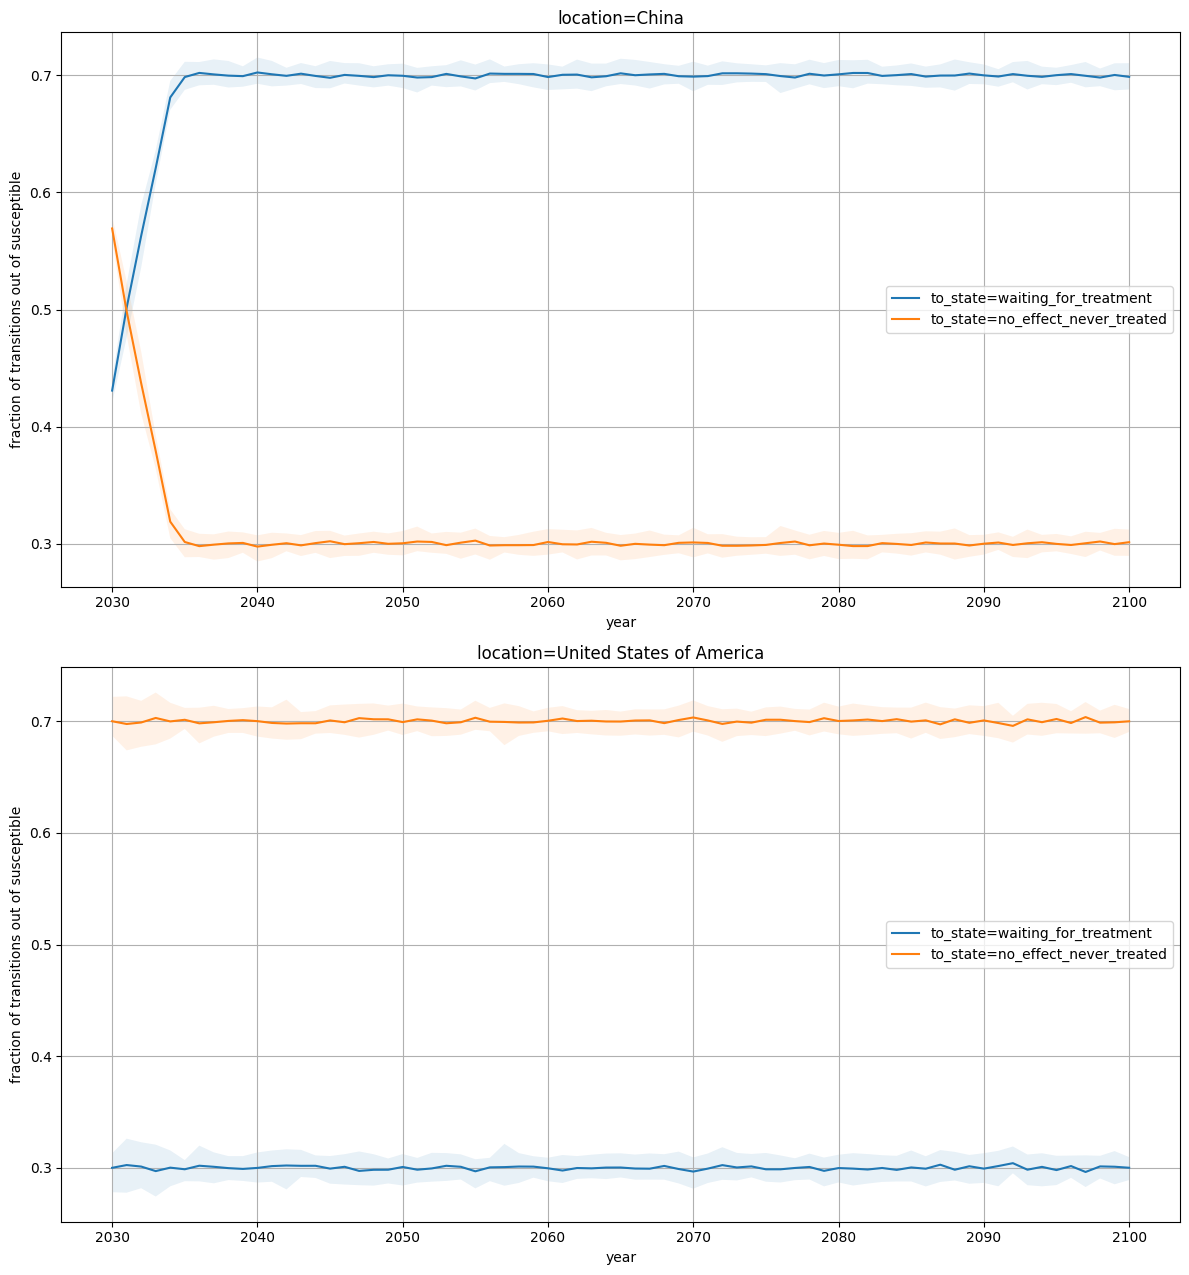

In [77]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [78]:
treatment_transitions.from_state.unique()

['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [79]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

input_draw                    scenario                  location  \
0            1  bbbm_testing_and_treatment                     China   
1            1  bbbm_testing_and_treatment                     China   
2            1  bbbm_testing_and_treatment  United States of America   
3            1  bbbm_testing_and_treatment  United States of America   
4            6  bbbm_testing_and_treatment                     China   
..         ...                         ...                       ...   
95         248  bbbm_testing_and_treatment  United States of America   
96         249  bbbm_testing_and_treatment                     China   
97         249  bbbm_testing_and_treatment                     China   
98         249  bbbm_testing_and_treatment  United States of America   
99         249  bbbm_testing_and_treatment  United States of America   

             to_state     value numerator_measure denominator_measure  \
0    full_effect_long  0.899905  transition_count    transition_count   
1   full_effect_short  0.100095  transition_count    transition_count   
2    full_effect_long  0.900385  transition_count    transition_count   
3   full_effect_short  0.099615  transition_count    transition_count   
4    full_effect_long  0.899876  transition_count    transition_count   
..                ...       ...               ...                 ...   
95  full_effect_short  0.100491  transition_count    transition_count   
96   full_effect_long  0.900024  transition_count    transition_count   
97  full_effect_short  0.099976  transition_count    transition_count   
98   full_effect_long  0.899418  transition_count    transition_count   
99  full_effect_short  0.100582  transition_count    transition_count   

    multiplier  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
95           1  
96           1  
97           1  
98           1  
99           1  

[100 rows x 8 columns]

In [80]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [81]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

input_draw                    scenario                  location     value  \
0         236  bbbm_testing_and_treatment                     China  8.958066   
1         236  bbbm_testing_and_treatment  United States of America  8.904691   
2         183  bbbm_testing_and_treatment                     China  9.094709   
3         183  bbbm_testing_and_treatment  United States of America  9.265543   
4         187  bbbm_testing_and_treatment                     China  8.970571   
5         187  bbbm_testing_and_treatment  United States of America  9.096383   
6          35  bbbm_testing_and_treatment                     China  9.013676   
7          35  bbbm_testing_and_treatment  United States of America  9.063417   
8         103  bbbm_testing_and_treatment                     China  8.994823   
9         103  bbbm_testing_and_treatment  United States of America  9.085264   
10        204  bbbm_testing_and_treatment                     China  9.072046   
11        204  bbbm_testing_and_treatment  United States of America  8.889927   
12         41  bbbm_testing_and_treatment                     China  9.164467   
13         41  bbbm_testing_and_treatment  United States of America  9.066840   
14        211  bbbm_testing_and_treatment                     China  9.078970   
15        211  bbbm_testing_and_treatment  United States of America  9.132414   
16        235  bbbm_testing_and_treatment                     China  9.061880   
17        235  bbbm_testing_and_treatment  United States of America  9.036919   
18         63  bbbm_testing_and_treatment                     China  9.007280   
19         63  bbbm_testing_and_treatment  United States of America  9.057749   
20        122  bbbm_testing_and_treatment                     China  9.014778   
21        122  bbbm_testing_and_treatment  United States of America  8.953404   
22         24  bbbm_testing_and_treatment                     China  9.023645   
23         24  bbbm_testing_and_treatment  United States of America  8.840509   
24         69  bbbm_testing_and_treatment                     China  8.998608   
25         69  bbbm_testing_and_treatment  United States of America  8.995894   
26        199  bbbm_testing_and_treatment                     China  8.919386   
27        199  bbbm_testing_and_treatment  United States of America  8.973042   
28        245  bbbm_testing_and_treatment                     China  8.980364   
29        245  bbbm_testing_and_treatment  United States of America  9.188213   
30        123  bbbm_testing_and_treatment                     China  9.006039   
31        123  bbbm_testing_and_treatment  United States of America  9.014220   
32        249  bbbm_testing_and_treatment                     China  9.002353   
33        249  bbbm_testing_and_treatment  United States of America  8.942138   
34          7  bbbm_testing_and_treatment                     China  8.910165   
35          7  bbbm_testing_and_treatment  United States of America  8.985699   
36          1  bbbm_testing_and_treatment                     China  8.990547   
37          1  bbbm_testing_and_treatment  United States of America  9.038641   
38        172  bbbm_testing_and_treatment                     China  9.016253   
39        172  bbbm_testing_and_treatment  United States of America  8.980577   
40          6  bbbm_testing_and_treatment                     China  8.987569   
41          6  bbbm_testing_and_treatment  United States of America  8.996103   
42        161  bbbm_testing_and_treatment                     China  9.060502   
43        161  bbbm_testing_and_treatment  United States of America  9.059495   
44        219  bbbm_testing_and_treatment                     China  9.030194   
45        219  bbbm_testing_and_treatment  United States of America  9.077374   
46        248  bbbm_testing_and_treatment                     China  8.930511   
47        248  bbbm_testing_and_treatment  United States of America  8.951134   
48         50  bbbm_testing_and_tr

In [82]:
# NOTE: ops.describe explicitly calculates uncertainty over
# ops.draw_col, so setting the draw column to 'random_seed' makes this
# work. Another option would be to allow passing in the "uncertainty"
# column instead of always assuming it's the input draw.
summarize_sim_data(complete_to_discontinue_ratio)

count  \
denominator_measure location                 multiplier numerator_measure scenario                            
transition_count    China                    1          transition_count  bbbm_testing_and_treatment   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment   25.0   

                                                                                                          mean  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  9.013748   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.021691   

                                                                                                           std  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  0.057117   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  0.093853   

                                                                                                           min  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  8.910165   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.840509   

                                                                                                           25%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  8.987569   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.953404   

                                                                                                          50%  \
denominator_measure location                 multiplier numerator_measure scenario                              
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  9.00728   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.01422   

                                                                                                           75%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  9.056303   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.066840   

                                                                                                           max  
denominator_measure location                 multiplier numerator_measure scenario                              
transition_count    China                    1          transition_count  bbbm_testing_and_treatment  9.164467  
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.265543

In [83]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                   
transition_count    China                    1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   

                                                                                                                            mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    China                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900134   
                                                                                                     full_effect_short  0.099866   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900208   
                                                                                                     full_effect_short  0.099792   

                                                                                                                             std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    China                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000568   
                                                                                                     full_effect_short  0.000568   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000930   
                                                                                                     full_effect_short  0.000930   

                                                                                                                             min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    China                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899094   
                                                                                                     full_effect_short  0.098382   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898379   
                                                                                                     full_effect_short  0.097413   

                                                                                                                             25%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    China                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899876   
                                                                                                     full_effect_short  0.099440   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899532   
                                                                                                     full_effect_short  0.099336   

                                                                                                                             50%  \
denominator_measure location             

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [84]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [85]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [86]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year  input_draw                    scenario  \
0            2030           1  bbbm_testing_and_treatment   
1            2030           1  bbbm_testing_and_treatment   
2            2030           1  bbbm_testing_and_treatment   
3            2030           1  bbbm_testing_and_treatment   
4            2030           1  bbbm_testing_and_treatment   
...           ...         ...                         ...   
17745        2100         249  bbbm_testing_and_treatment   
17746        2100         249  bbbm_testing_and_treatment   
17747        2100         249  bbbm_testing_and_treatment   
17748        2100         249  bbbm_testing_and_treatment   
17749        2100         249  bbbm_testing_and_treatment   

                       location             sub_entity      value  \
0                         China  waiting_for_treatment   1.000000   
1                         China       full_effect_long   0.000000   
2                         China      full_effect_short   0.000000   
3                         China     waning_effect_long   0.000000   
4                         China    waning_effect_short   0.000000   
...                         ...                    ...        ...   
17745  United States of America  waiting_for_treatment   1.000000   
17746  United States of America       full_effect_long   8.313237   
17747  United States of America      full_effect_short   0.089777   
17748  United States of America     waning_effect_long  10.665138   
17749  United States of America    waning_effect_short   0.466579   

      numerator_measure denominator_measure  multiplier  
0           person_time         person_time           1  
1           person_time         person_time           1  
2           person_time         person_time           1  
3           person_time         person_time           1  
4           person_time         person_time           1  
...                 ...                 ...         ...  
17745       person_time         person_time           1  
17746       person_time         person_time           1  
17747       person_time         person_time           1  
17748       person_time         person_time           1  
17749       person_time         person_time           1  

[17750 rows x 9 columns]

In [87]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                    
waiting_for_treatment       0.5                  1.0                       1.0
full_effect_long            5.0                  0.9                       9.0
full_effect_short           0.5                  0.1                       0.1
waning_effect_long          9.0                  0.9                      16.2
waning_effect_short         2.5                  0.1                       0.5

In [88]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


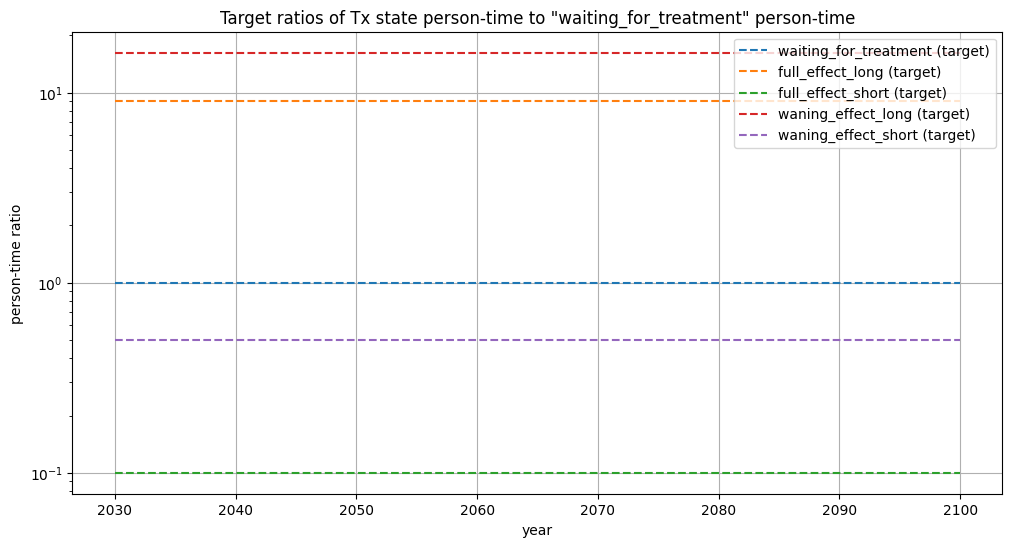

In [89]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

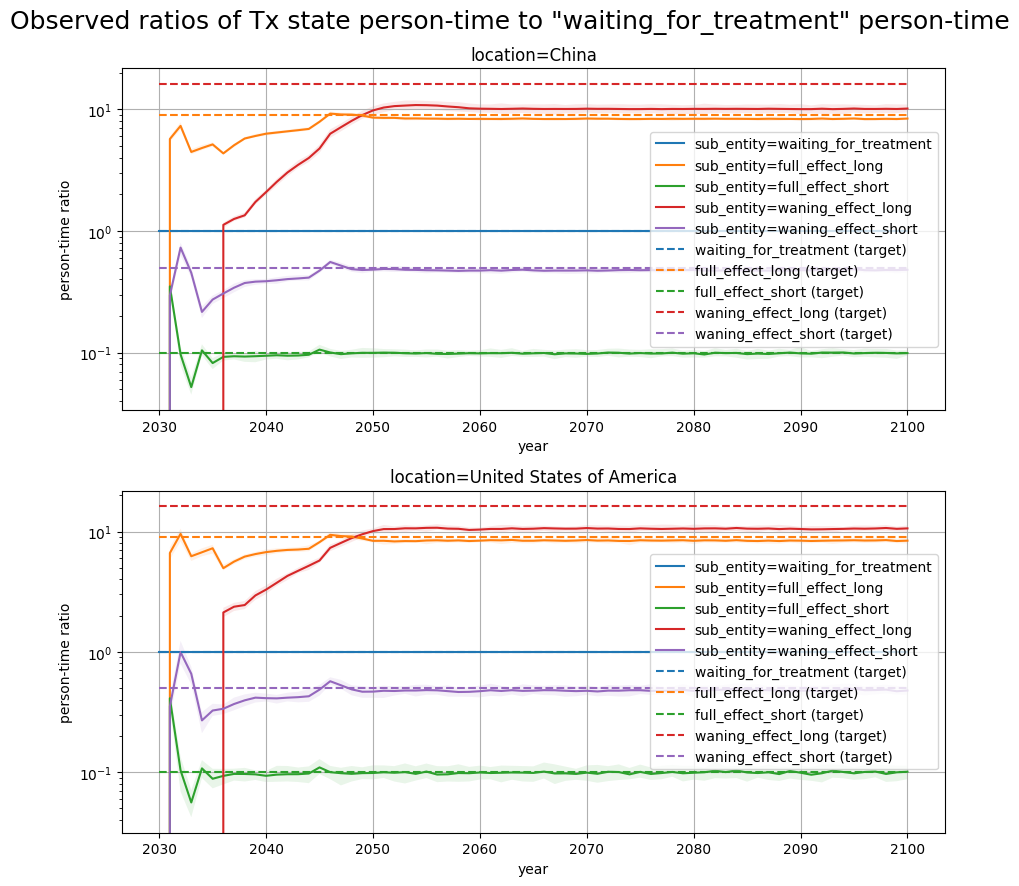

In [90]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

In [91]:
tx_person_time_ratios.groupby(['event_year', 'sub_entity'])['value'].describe()

count       mean       std       min  \
event_year sub_entity                                                    
2030       full_effect_long        50.0   0.000000  0.000000  0.000000   
           full_effect_short       50.0   0.000000  0.000000  0.000000   
           waiting_for_treatment   50.0   1.000000  0.000000  1.000000   
           waning_effect_long      50.0   0.000000  0.000000  0.000000   
           waning_effect_short     50.0   0.000000  0.000000  0.000000   
...                                 ...        ...       ...       ...   
2100       full_effect_long        50.0   8.402769  0.201610  7.920312   
           full_effect_short       50.0   0.099886  0.005680  0.085862   
           waiting_for_treatment   50.0   1.000000  0.000000  1.000000   
           waning_effect_long      50.0  10.390253  0.484618  9.427020   
           waning_effect_short     50.0   0.478306  0.017701  0.425404   

                                        25%        50%        75%        max  
event_year sub_entity                                                         
2030       full_effect_long        0.000000   0.000000   0.000000   0.000000  
           full_effect_short       0.000000   0.000000   0.000000   0.000000  
           waiting_for_treatment   1.000000   1.000000   1.000000   1.000000  
           waning_effect_long      0.000000   0.000000   0.000000   0.000000  
           waning_effect_short     0.000000   0.000000   0.000000   0.000000  
...                                     ...        ...        ...        ...  
2100       full_effect_long        8.302437   8.399737   8.531425   8.867950  
           full_effect_short       0.096864   0.099318   0.103472   0.114162  
           waiting_for_treatment   1.000000   1.000000   1.000000   1.000000  
           waning_effect_long     10.080814  10.438845  10.727095  11.264787  
           waning_effect_short     0.467273   0.479784   0.491419   0.520954  

[355 rows x 8 columns]

## Check values

In [92]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean       10.330367
std         0.506398
min         9.047644
25%        10.028008
50%        10.392487
75%        10.683112
max        11.647427
Name: value, dtype: float64

In [93]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean        8.387300
std         0.196789
min         7.685993
25%         8.257734
50%         8.383054
75%         8.507690
max         9.109220
Name: value, dtype: float64

In [94]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

In [95]:
ops.index_cols

['input_draw', 'scenario', 'location']

## Look at actual person-time instead of the ratio

In [96]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2050"
            # " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location                 scenario                   sub_entity                     
2051       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
                                                               waning_effect_long      25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
...                                                                                     ...   
2100       China                    bbbm_testing_and_treatment full_effect_long        25.0   
                                                               waning_effect_long      25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
                                                               waning_effect_long      25.0   

                                                                                              mean  \
event_year location                 scenario                   sub_entity                            
2051       China                    bbbm_testing_and_treatment waiting_for_treatment   2846.883614   
                                                               full_effect_long       24231.009117   
                                                               waning_effect_long     29445.542067   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    727.083149   
                                                               full_effect_long        6085.482053   
...                                                                                            ...   
2100       China                    bbbm_testing_and_treatment full_effect_long       23634.956003   
                                                               waning_effect_long     28570.666448   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    737.208378   
                                                               full_effect_long        6189.524764   
                                                               waning_effect_long      7826.124572   

                                                                                              std  \
event_year location                 scenario                   sub_entity                           
2051       China                    bbbm_testing_and_treatment waiting_for_treatment   158.304682   
                                                               full_effect_long       1391.257252   
                                                               waning_effect_long     1925.933971   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    43.339119   
                                                               full_effect_long        264.636387   
...                                                                                           ...   
2100       China                    bbbm_testing_and_treatment full_effect_long       1308.348495   
                                                               waning_effect_long     2158.273170   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    34.241460   
                                                               full_effect_long        242.774506   
                                                               waning_effect_long      292.142419   

                                                                                               min  \
event_year location                 scenario                   sub_entity                            
2051 

In [97]:
9721.296427 / 1129.481287

8.606868071998433

In [98]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [99]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2132995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        236  person_time   
1        treatment       cause        2022        236  person_time   
2        treatment       cause        2022        236  person_time   
3        treatment       cause        2022        236  person_time   
4        treatment       cause        2022        236  person_time   
...            ...         ...         ...        ...          ...   
2132995  treatment       cause        2100         50  person_time   
2132996  treatment       cause        2100         50  person_time   
2132997  treatment       cause        2100         50  person_time   
2132998  treatment       cause        2100         50  person_time   
2132999  treatment       cause        2100         50  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
2132995  bbbm_testing_and_treatment    Male        waning_effect_long   
2132996  bbbm_testing_and_treatment    Male       waning_effect_short   
2132997  bbbm_testing_and_treatment    Male      no_effect_after_long   
2132998  bbbm_testing_and_treatment    Male     no_effect_after_short   
2132999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.000000  United States of America  
1          0.000000  United States of America  
2          0.000000  United States of America  
3          0.000000  United States of America  
4          0.000000  United States of America  
...             ...                       ...  
2132995    0.000000                     China  
2132996    0.000000                     China  
2132997  142.510609                     China  
2132998    8.969199                     China  
2132999   29.399042                     China  

[2133000 rows x 12 columns]

In [100]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
445600  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445601  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445606  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445607  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445608  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
884764  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884772  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884780  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884788  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884796  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
445600  treatment       cause       2030        236  United States of America   
445601  treatment       cause       2030        236  United States of America   
445606  treatment       cause       2030        236  United States of America   
445607  treatment       cause       2030        236  United States of America   
445608  treatment       cause       2030        236  United States of America   
...           ...         ...        ...        ...                       ...   
884764  treatment       cause       2100        219                     China   
884772  treatment       cause       2100        248                     China   
884780  treatment       cause       2100        248                     China   
884788  treatment       cause       2100         50                     China   
884796  treatment       cause       2100         50                     China   

                 measure                    scenario     sex  \
445600  transition_count  bbbm_testing_and_treatment  Female   
445601  transition_count  bbbm_testing_and_treatment  Female   
445606  transition_count  bbbm_testing_and_treatment  Female   
445607  transition_count  bbbm_testing_and_treatment  Female   
445608  transition_count  bbbm_testing_and_treatment    Male   
...                  ...                         ...     ...   
884764  transition_count  bbbm_testing_and_treatment    Male   
884772  transition_count  bbbm_testing_and_treatment  Female   
884780  transition_count  bbbm_testing_and_treatment    Male   
884788  transition_count  bbbm_testing_and_treatment  Female   
884796  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
445600          waiting_for_treatment_to_full_effect_long   41.0   
445601         waiting_for_treatment_to_full_effect_short    6.0   
445606  susceptible_to_treatment_to_waiting_for_treatment   64.0   
445607  susceptible_to_treatment_to_no_effect_never_tr...  151.0   
445608          waiting_for_treatment_to_full_effect_long   29.0   
...                                                   ...    ...   
884764         waning_effect_long_to_no_effect_after_long  103.0   
884772         waning_effect_long_to_no_effect_after_long  224.0   
884780         waning_effect_long_to_no_effect_after_long   36.0   
884788         waning_effect_long_to_no_effect_after_long  314.0   
884796         waning_effect_long_to_no_effect_after_long   86.0   

                      from_state                 to_state  
445600     waiting_for_treatment         full_effect_long  
445601     waiting_for_treatment        full_effect_short  
445606  susceptible_to_treatment    waiting_for_treatment  
445607  susceptible_to_treatment  no_effect_never_treated  
445608     waiting_for_treatment         full_effect_long  
...                          ...                      ...  
884764        waning_effect_long     no_effect_after_long  
884772        waning_effect_long     no_effect_after_long  
884780        waning_effect_long     no_effect_after_lo

In [101]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year             to_state  input_draw  \
0            2030     full_effect_long           1   
1            2030     full_effect_long           1   
2            2030     full_effect_long           6   
3            2030     full_effect_long           6   
4            2030     full_effect_long           7   
...           ...                  ...         ...   
31945        2100  waning_effect_short         245   
31946        2100  waning_effect_short         248   
31947        2100  waning_effect_short         248   
31948        2100  waning_effect_short         249   
31949        2100  waning_effect_short         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     China  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment                     China  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment                     China  0.000000   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.450489   
31946  bbbm_testing_and_treatment                     China  2.453407   
31947  bbbm_testing_and_treatment  United States of America  2.617933   
31948  bbbm_testing_and_treatment                     China  2.528151   
31949  bbbm_testing_and_treatment  United States of America  2.608689   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

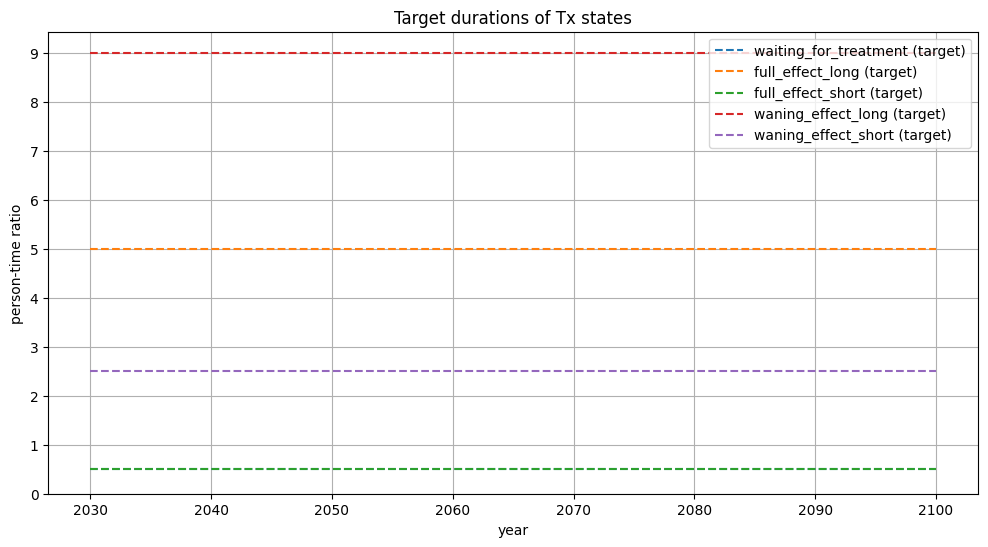

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

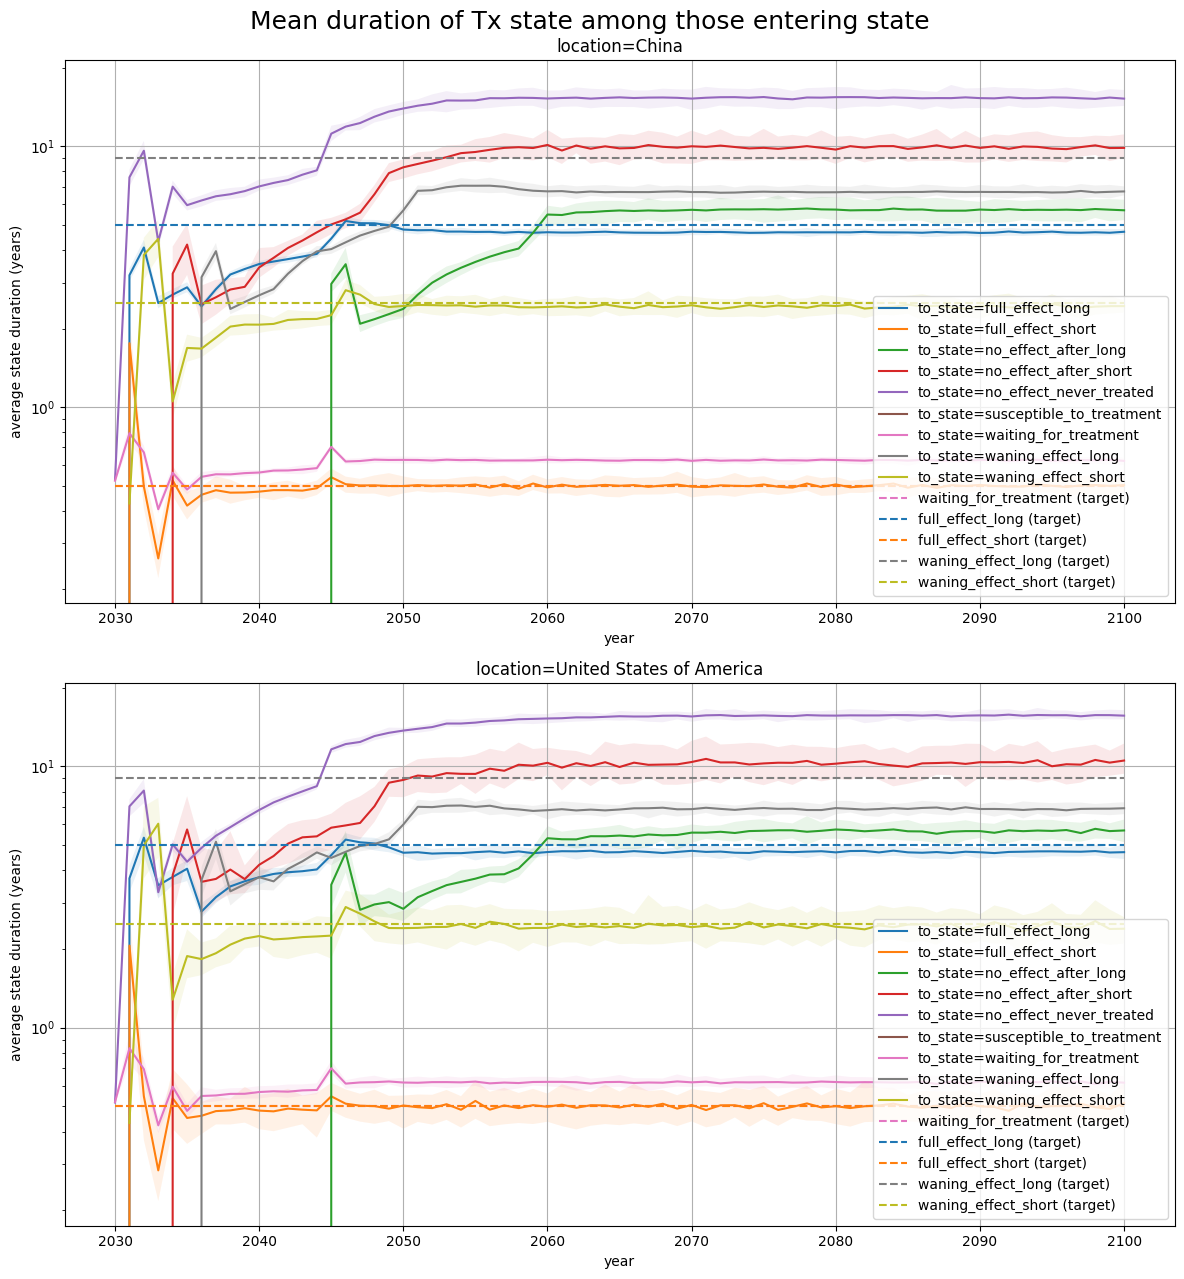

In [103]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [104]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year           from_state  input_draw  \
0            2030     full_effect_long           1   
1            2030     full_effect_long           1   
2            2030     full_effect_long           6   
3            2030     full_effect_long           6   
4            2030     full_effect_long           7   
...           ...                  ...         ...   
31945        2100  waning_effect_short         245   
31946        2100  waning_effect_short         248   
31947        2100  waning_effect_short         248   
31948        2100  waning_effect_short         249   
31949        2100  waning_effect_short         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     China       NaN   
1      bbbm_testing_and_treatment  United States of America       NaN   
2      bbbm_testing_and_treatment                     China       NaN   
3      bbbm_testing_and_treatment  United States of America       NaN   
4      bbbm_testing_and_treatment                     China       NaN   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.650158   
31946  bbbm_testing_and_treatment                     China  2.661667   
31947  bbbm_testing_and_treatment  United States of America  3.122305   
31948  bbbm_testing_and_treatment                     China  2.469039   
31949  bbbm_testing_and_treatment  United States of America  2.430011   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

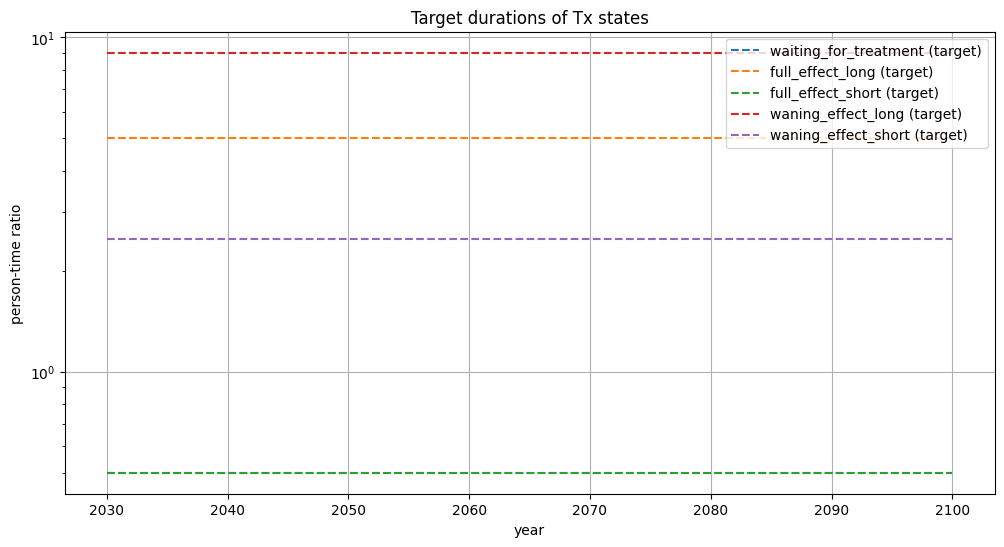

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

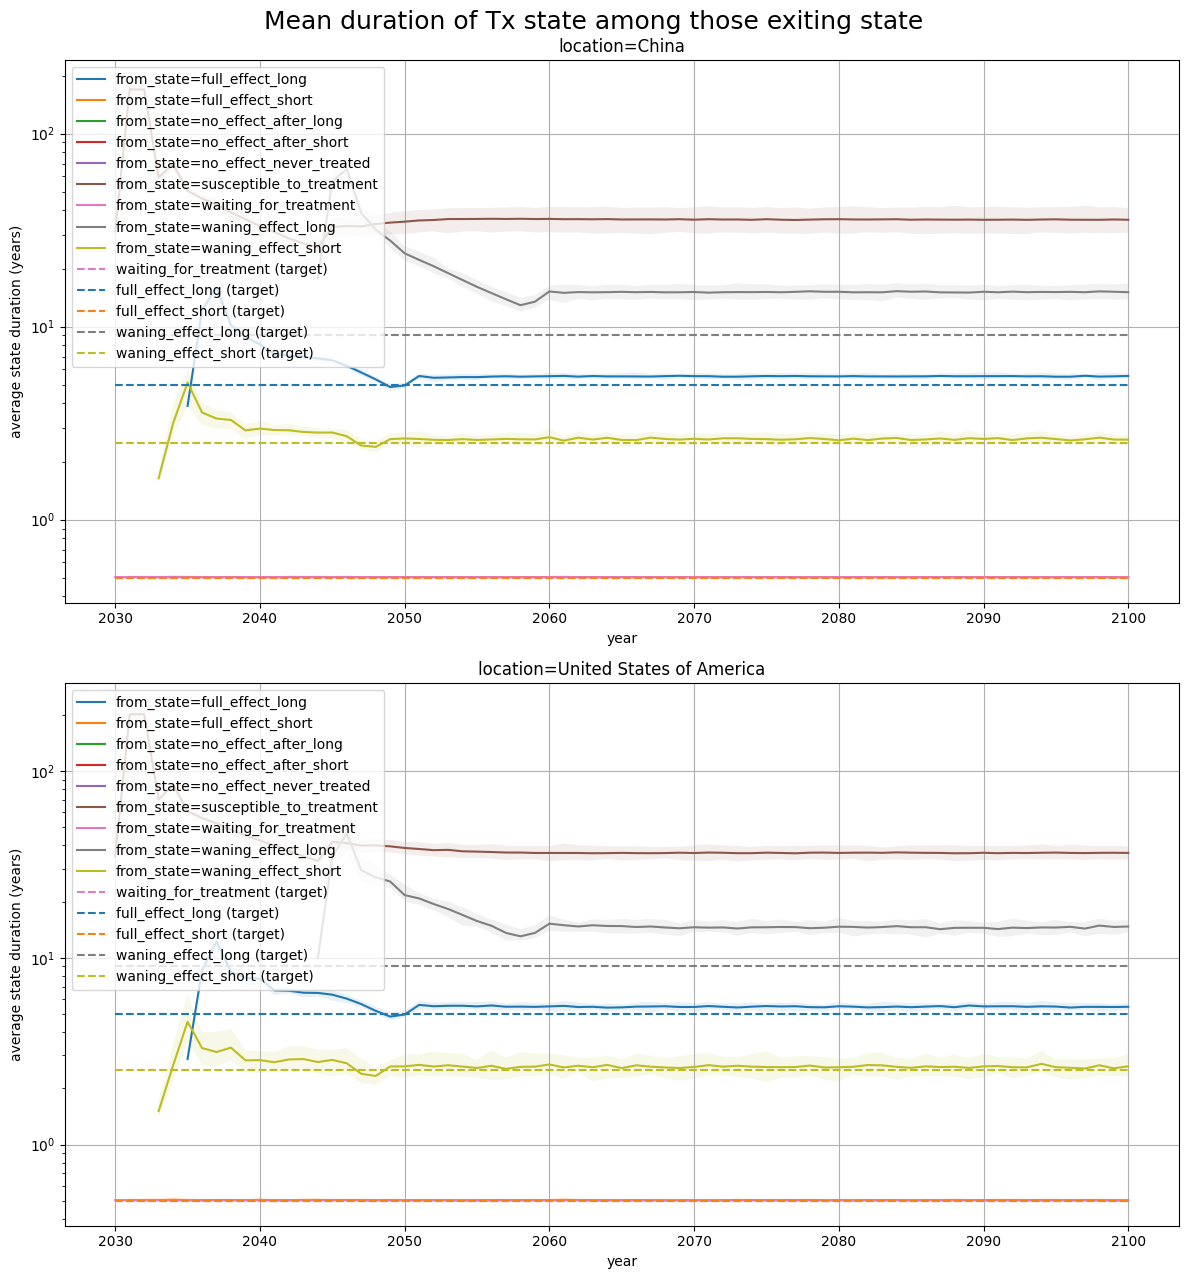

In [106]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [107]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        6.802721
std         0.248460
min         6.025199
25%         6.625347
50%         6.794744
75%         6.965715
max         7.658562
Name: value, dtype: float64

In [108]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean       15.147155
std         1.585357
min        11.883011
25%        14.280199
50%        14.849706
75%        15.584981
max        25.003856
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [109]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        4.690978
std         0.111691
min         4.226686
25%         4.620317
50%         4.688631
75%         4.759241
max         5.117426
Name: value, dtype: float64

In [110]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        5.503498
std         0.137061
min         5.014217
25%         5.417748
50%         5.506142
75%         5.593006
max         5.943810
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [111]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias',
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


134.384577 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
6398995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
6398995  alzheimers_disease_and_other_dementias       cause        2100   
6398996  alzheimers_disease_and_other_dementias       cause        2100   
6398997  alzheimers_disease_and_other_dementias       cause        2100   
6398998  alzheimers_disease_and_other_dementias       cause        2100   
6398999  alzheimers_disease_and_other_dementias       cause        2100   

        input_draw      measure                    scenario     sex  \
0              236  person_time                    baseline  Female   
1              236  person_time                    baseline  Female   
2              236  person_time                    baseline  Female   
3              236  person_time                    baseline  Female   
4              236  person_time                    baseline  Female   
...            ...          ...                         ...     ...   
6398995         50  person_time  bbbm_testing_and_treatment    Male   
6398996         50  person_time  bbbm_testing_and_treatment    Male   
6398997         50  person_time  bbbm_testing_and_treatment    Male   
6398998         50  person_time  bbbm_testing_and_treatment    Male   
6398999         50  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity                 treatment  \
0        alzheimers_blood_based_biomarker_state  susceptible_to_treatment   
1        alzheimers_blood_based_biomarker_state     waiting_for_treatment   
2        alzheimers_blood_based_biomarker_state          full_effect_long   
3        alzheimers_blood_based_biomarker_state         full_effect_short   
4        alzheimers_blood_based_biomarker_state        waning_effect_long   
...                                         ...                       ...   
6398995                alzheimers_disease_state        waning_effect_long   
6398996                alzheimers_disease_state       waning_effect_short   
6398997                alzheimers_disease_state      no_effect_after_long   
6398998                alzheimers_disease_state     no_effect_after_short   
6398999                alzheimers_disease_state   no_effect_never_treated   

             value                  location  
0         0.000000  United States of America  
1         0.000000  United States of America  
2         0.000000  United States of America  
3         0.000000  United States of America  
4         0.000000  United States of America  
...            ...                       ...  
6398995   0.000000                     China  
6398996   0.000000                     China  
6398997  96.668036                     Ch

In [112]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [113]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [114]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [115]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias',
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
89.591575 MB
887.333575 MB
93.860901 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
4265995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
0        alzheimers_disease_and_other_dementias       cause       2022   
1        alzheimers_disease_and_other_dementias       cause       2022   
2        alzheimers_disease_and_other_dementias       cause       2022   
3        alzheimers_disease_and_other_dementias       cause       2022   
4        alzheimers_disease_and_other_dementias       cause       2022   
...                                         ...         ...        ...   
4265995  alzheimers_disease_and_other_dementias       cause       2100   
4265996  alzheimers_disease_and_other_dementias       cause       2100   
4265997  alzheimers_disease_and_other_dementias       cause       2100   
4265998  alzheimers_disease_and_other_dementias       cause       2100   
4265999  alzheimers_disease_and_other_dementias       cause       2100   

        input_draw           measure                    scenario     sex  \
0              236  transition_count                    baseline  Female   
1              236  transition_count                    baseline  Female   
2              236  transition_count                    baseline  Female   
3              236  transition_count                    baseline  Female   
4              236  transition_count                    baseline  Female   
...            ...               ...                         ...     ...   
4265995         50  transition_count  bbbm_testing_and_treatment    Male   
4265996         50  transition_count  bbbm_testing_and_treatment    Male   
4265997         50  transition_count  bbbm_testing_and_treatment    Male   
4265998         50  transition_count  bbbm_testing_and_treatment    Male   
4265999         50  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
4265995  alzheimers_mild_cognitive_impairment_state_to_...   
4265996  alzheimers_mild_cognitive_impairment_state_to_...   
4265997  alzheimers_mild_cognitive_impairment_state_to_...   
4265998  alzheimers_mild_cognitive_impairment_state_to_...   
4265999  alzheimers_mild_cognitive_impairment_state_to_...   

                        treatment  value                  location  \
0        susceptible_to_treatment    0.0  United States of America   
1           waiting_for_treatment    0.0  United States of America   
2                full_effect_long    0.0  United States of America   
3               full_effect_short    0.0  United States of America   
4              waning_effect_long    0.0  United States of America   
...                           ...    ...                       ...   
4265995        waning_effect_long    0.0                     China   
4265996       waning_effect_short   

In [116]:
transition_count_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year       category
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
from_state       category
to_state         category
dtype: object

In [117]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [118]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # doesn't actually broadcast, just records it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2022      alzheimers_blood_based_biomarker_state   
1            2022      alzheimers_blood_based_biomarker_state   
2            2022      alzheimers_blood_based_biomarker_state   
3            2022      alzheimers_blood_based_biomarker_state   
4            2022      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
66587        2100  alzheimers_mild_cognitive_impairment_state   
66588        2100  alzheimers_mild_cognitive_impairment_state   
66589        2100  alzheimers_mild_cognitive_impairment_state   
66590        2100  alzheimers_mild_cognitive_impairment_state   
66591        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           1                    baseline   
1      susceptible_to_treatment           1                    baseline   
2      susceptible_to_treatment           1  bbbm_testing_and_treatment   
3      susceptible_to_treatment           1  bbbm_testing_and_treatment   
4      susceptible_to_treatment           6                    baseline   
...                         ...         ...                         ...   
66587       waning_effect_short         245  bbbm_testing_and_treatment   
66588       waning_effect_short         248  bbbm_testing_and_treatment   
66589       waning_effect_short         248  bbbm_testing_and_treatment   
66590       waning_effect_short         249  bbbm_testing_and_treatment   
66591       waning_effect_short         249  bbbm_testing_and_treatment   

                       location                                    to_state  \
0                         China  alzheimers_mild_cognitive_impairment_state   
1      United States of America  alzheimers_mild_cognitive_impairment_state   
2                         China  alzheimers_mild_cognitive_impairment_state   
3      United States of America  alzheimers_mild_cognitive_impairment_state   
4                         China  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
66587  United States of America                    alzheimers_disease_state   
66588                     China                    alzheimers_disease_state   
66589  United States of America                    alzheimers_disease_state   
66590                     China                    alzheimers_disease_state   
66591  United States of America                    alzheimers_disease_state   

          value          measure numerator_measure denominator_measure  \
0      0.143771  transition_rate  transition_count         person_time   
1      0.142903  transition_rate  transition_count         person_time   
2      0.143771  transition_rate  transition_count         person_time   
3      0.142903  transition_rate  transition_count         person_time   
4      0.140881  transition_rate  transition_count         person_time   
...         ...              ...               ...                 ...   
66587  0.161266  transition_rate  transition_count         person_time   
66588  0.201808  transition_rate  transition_count         person_time   
66589  0.286695  transition_rate  transition_count         person_time   
66590  0.291638  transition_rate  transition_count         person_time   
66591  0.252967  transition_rate  transition_count         person_time   

       multiplier  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
66587           1  
66588           1  
66589           1  
66590           1  
66591           1  

[66592 rows x 12 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [119]:
incidence_rates_by_treatment.value.describe()

count    6.659200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.357967e-01
50%      1.861693e-01
75%      2.514931e-01
max               inf
Name: value, dtype: float64

In [120]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

399 rows with infinite values


event_year                                  from_state  \
1600         2030      alzheimers_blood_based_biomarker_state   
1601         2030      alzheimers_blood_based_biomarker_state   
1602         2030      alzheimers_blood_based_biomarker_state   
1603         2030      alzheimers_blood_based_biomarker_state   
1604         2030      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
13087        2044  alzheimers_mild_cognitive_impairment_state   
13088        2044  alzheimers_mild_cognitive_impairment_state   
13089        2044  alzheimers_mild_cognitive_impairment_state   
13090        2044  alzheimers_mild_cognitive_impairment_state   
13091        2044  alzheimers_mild_cognitive_impairment_state   

                  treatment  input_draw                    scenario  \
1600       full_effect_long           1  bbbm_testing_and_treatment   
1601       full_effect_long           1  bbbm_testing_and_treatment   
1602       full_effect_long           6  bbbm_testing_and_treatment   
1603       full_effect_long           6  bbbm_testing_and_treatment   
1604       full_effect_long           7  bbbm_testing_and_treatment   
...                     ...         ...                         ...   
13087  no_effect_after_long         245  bbbm_testing_and_treatment   
13088  no_effect_after_long         248  bbbm_testing_and_treatment   
13089  no_effect_after_long         248  bbbm_testing_and_treatment   
13090  no_effect_after_long         249  bbbm_testing_and_treatment   
13091  no_effect_after_long         249  bbbm_testing_and_treatment   

                       location                                    to_state  \
1600                      China  alzheimers_mild_cognitive_impairment_state   
1601   United States of America  alzheimers_mild_cognitive_impairment_state   
1602                      China  alzheimers_mild_cognitive_impairment_state   
1603   United States of America  alzheimers_mild_cognitive_impairment_state   
1604                      China  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
13087  United States of America                    alzheimers_disease_state   
13088                     China                    alzheimers_disease_state   
13089  United States of America                    alzheimers_disease_state   
13090                     China                    alzheimers_disease_state   
13091  United States of America                    alzheimers_disease_state   

       value          measure numerator_measure denominator_measure  \
1600     inf  transition_rate  transition_count         person_time   
1601     inf  transition_rate  transition_count         person_time   
1602     inf  transition_rate  transition_count         person_time   
1603     inf  transition_rate  transition_count         person_time   
1604     inf  transition_rate  transition_count         person_time   
...      ...              ...               ...                 ...   
13087    inf  transition_rate  transition_count         person_time   
13088    inf  transition_rate  transition_count         person_time   
13089    inf  transition_rate  transition_count         person_time   
13090    inf  transition_rate  transition_count         person_time   
13091    inf  transition_rate  transition_count         person_time   

       multiplier  
1600            1  
1601            1  
1602            1  
1603            1  
1604            1  
...           ...  
13087           1  
13088           1  
13089           1  
13090           1  
13091           1  

[399 rows x 12 columns]

In [121]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location, from_state, to_state]
Index: []

In [122]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location]
Index: []

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

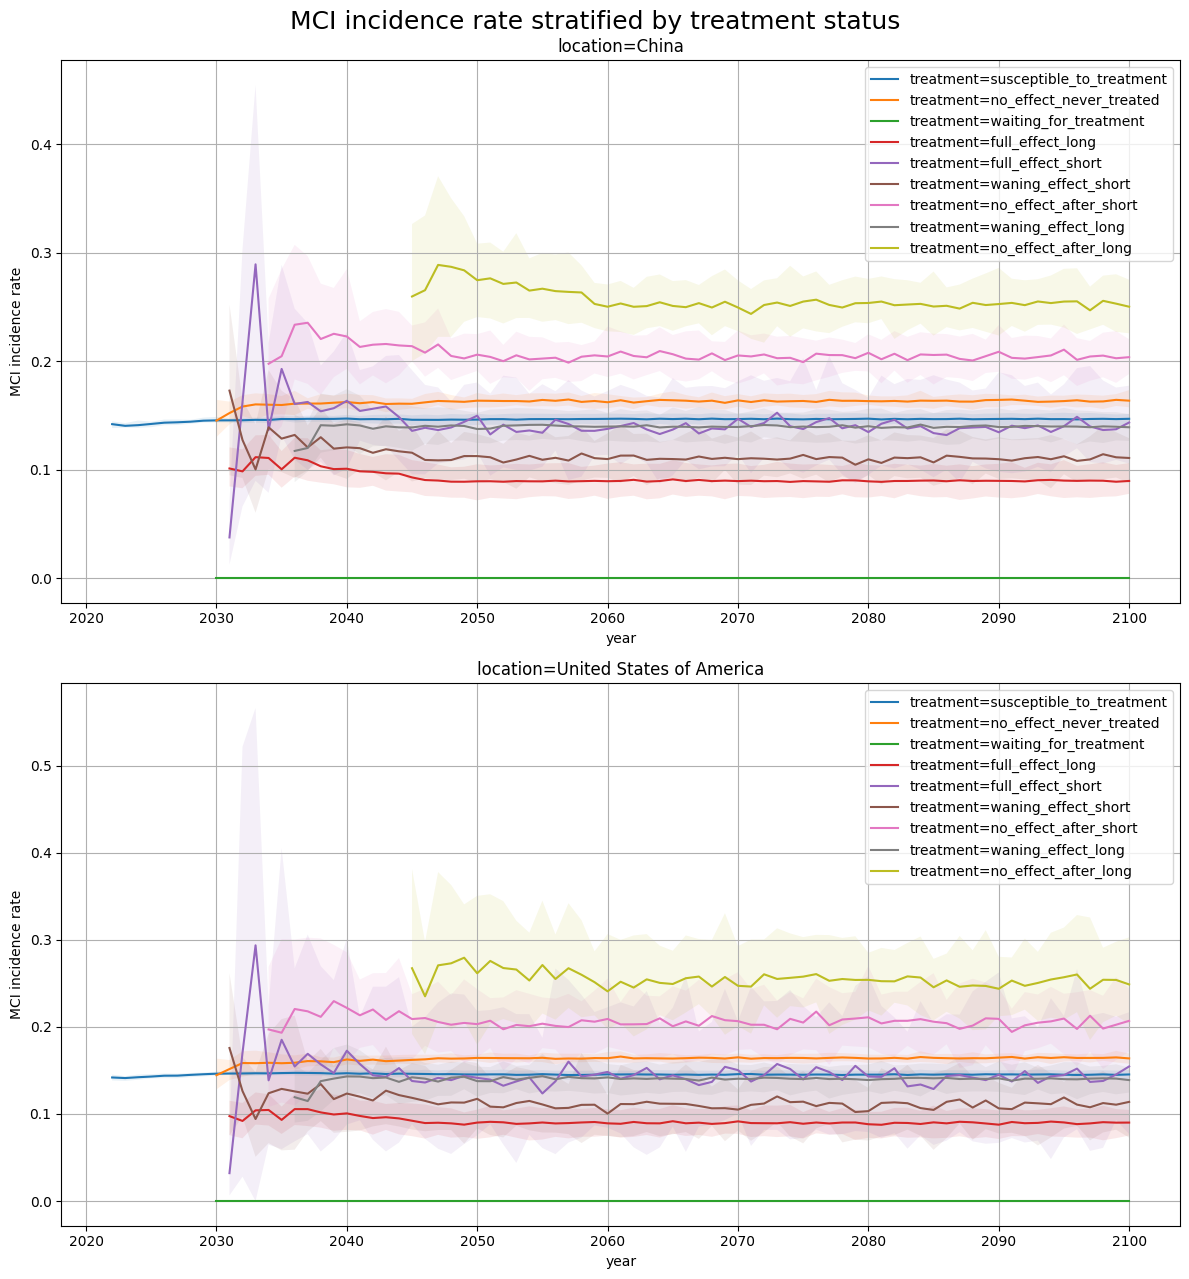

In [123]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

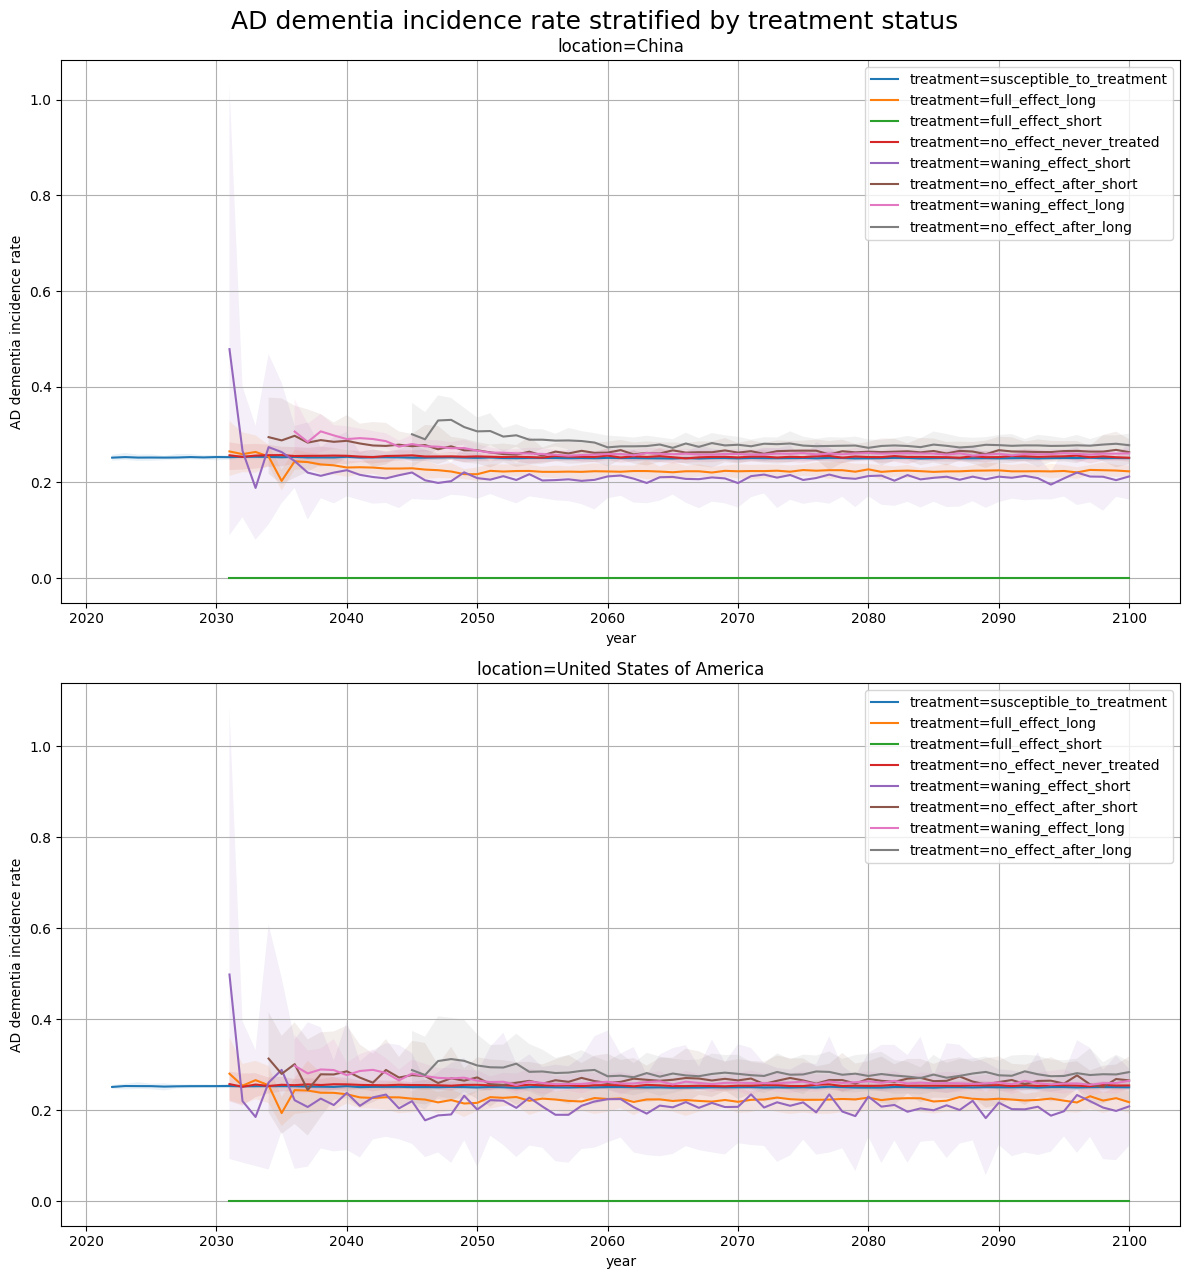

In [124]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [125]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

event_year                                  from_state  input_draw  \
0            2022      alzheimers_blood_based_biomarker_state           1   
1            2022      alzheimers_blood_based_biomarker_state           1   
2            2022      alzheimers_blood_based_biomarker_state           1   
3            2022      alzheimers_blood_based_biomarker_state           1   
4            2022      alzheimers_blood_based_biomarker_state           6   
...           ...                                         ...         ...   
66587        2100  alzheimers_mild_cognitive_impairment_state         249   
66588        2100  alzheimers_mild_cognitive_impairment_state         249   
66589        2100  alzheimers_mild_cognitive_impairment_state         249   
66590        2100  alzheimers_mild_cognitive_impairment_state         249   
66591        2100  alzheimers_mild_cognitive_impairment_state         249   

                         scenario                  location  \
0                        baseline                     China   
1                        baseline  United States of America   
2      bbbm_testing_and_treatment                     China   
3      bbbm_testing_and_treatment  United States of America   
4                        baseline                     China   
...                           ...                       ...   
66587  bbbm_testing_and_treatment  United States of America   
66588  bbbm_testing_and_treatment  United States of America   
66589  bbbm_testing_and_treatment  United States of America   
66590  bbbm_testing_and_treatment  United States of America   
66591  bbbm_testing_and_treatment  United States of America   

                      treatment     value numerator_measure  \
0      susceptible_to_treatment  1.000000   transition_rate   
1      susceptible_to_treatment  1.000000   transition_rate   
2      susceptible_to_treatment  1.000000   transition_rate   
3      susceptible_to_treatment  1.000000   transition_rate   
4      susceptible_to_treatment  1.000000   transition_rate   
...                         ...       ...               ...   
66587     no_effect_after_short  1.054223   transition_rate   
66588   no_effect_never_treated  1.039618   transition_rate   
66589  susceptible_to_treatment  1.000000   transition_rate   
66590        waning_effect_long  1.050131   transition_rate   
66591       waning_effect_short  1.015017   transition_rate   

      denominator_measure  multiplier  
0         transition_rate           1  
1         transition_rate           1  
2         transition_rate           1  
3         transition_rate           1  
4         transition_rate           1  
...                   ...         ...  
66587     transition_rate           1  
66588     transition_rate           1  
66589     transition_rate           1  
66590     transition_rate           1  
66591     transition_rate           1  

[66592 rows x 10 columns]

In [126]:
hazard_ratio.value.describe()

count    6.659200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      8.498039e-01
50%      1.000000e+00
75%      1.073145e+00
max               inf
Name: value, dtype: float64

In [127]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

399 rows with infinite values


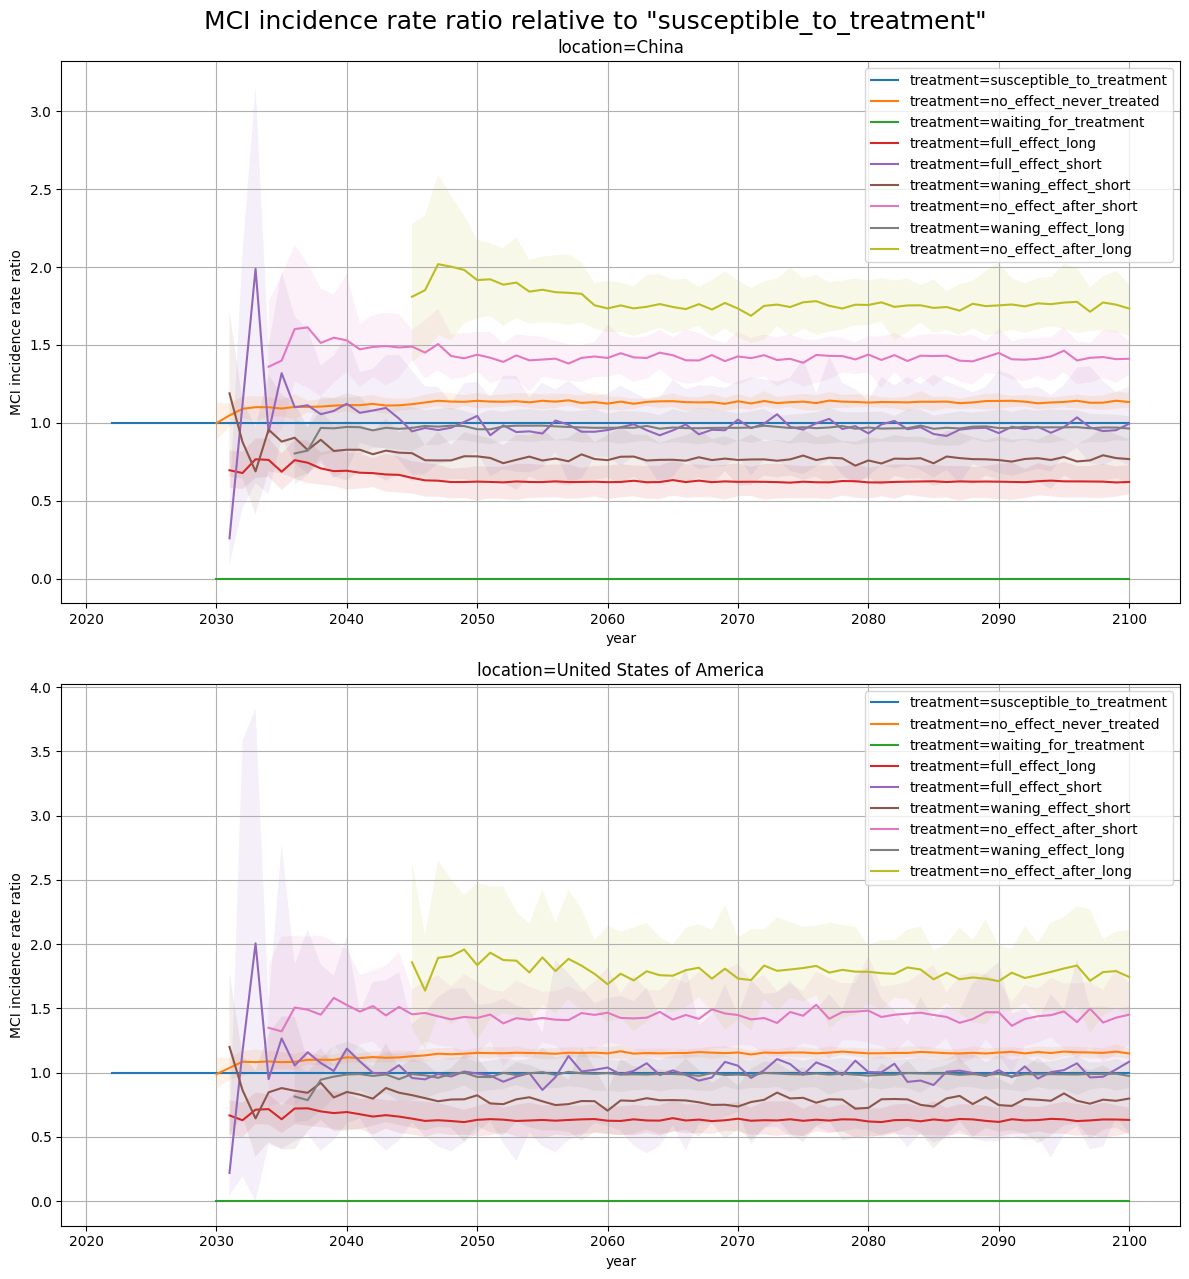

In [128]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

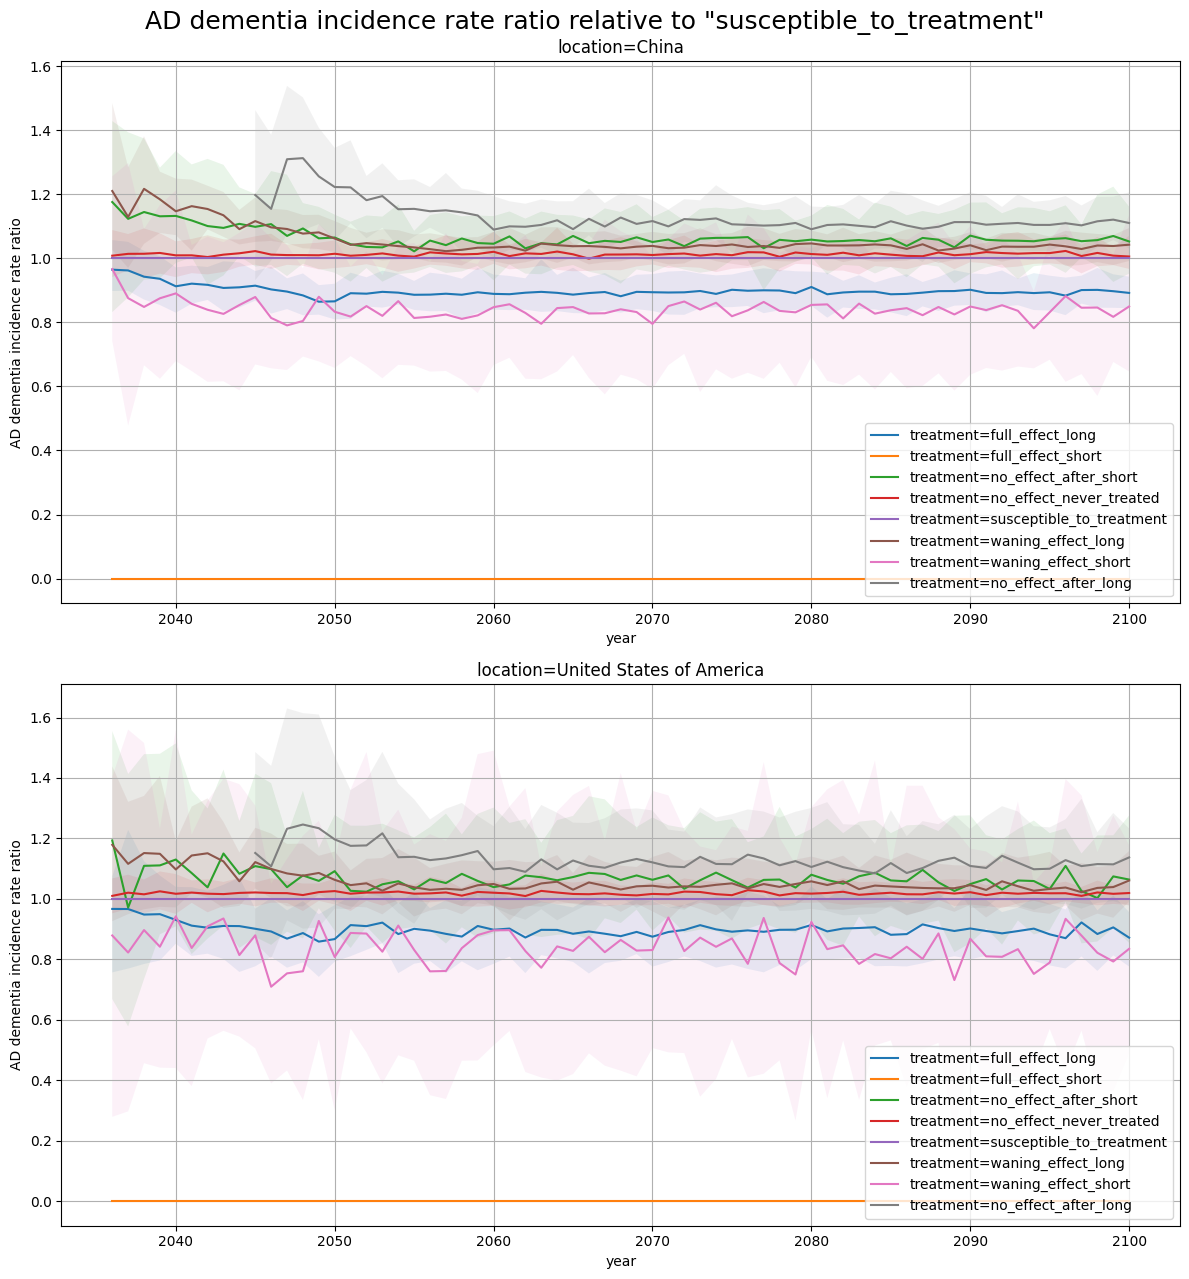

In [129]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [130]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


9.010252 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236  deaths   
1       alzheimers_disease_state       cause        2022        236  deaths   
2       alzheimers_disease_state       cause        2022        236  deaths   
3       alzheimers_disease_state       cause        2022        236  deaths   
4       alzheimers_disease_state       cause        2022        183  deaths   
...                          ...         ...         ...        ...     ...   
473995              other_causes       cause        2100        248  deaths   
473996              other_causes       cause        2100         50  deaths   
473997              other_causes       cause        2100         50  deaths   
473998              other_causes       cause        2100         50  deaths   
473999              other_causes       cause        2100         50  deaths   

                          scenario     sex   value                  location  
0                         baseline  Female     0.0  United States of America  
1                         baseline    Male     0.0  United States of America  
2       bbbm_testing_and_treatment  Female     0.0  United States of America  
3       bbbm_testing_and_treatment    Male     0.0  United States of America  
4                         baseline  Female     0.0  United States of America  
...                            ...     ...     ...                       ...  
473995  bbbm_testing_and_treatment    Male   186.0                     China  
473996                    baseline  Female  2979.0                     China  
473997                    baseline    Male   297.0                     China  
473998  bbbm_testing_and_treatment  Female  3048.0                     China  
473999  bbbm_testing_and_treatment    Male   312.0                     China  

[474000 rows x 11 columns]

In [131]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

9.010252 MB measure
6.40312 MB minuend
6.40312 MB subtrahend
4.273424 MB minuend re-indexed
4.273424 MB subtrahend re-indexed
4.273484 MB difference
5.929252 MB difference with reset index
6.166577 MB final difference
6.166577 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
236995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236  deaths   
1       alzheimers_disease_state       cause        2022        236  deaths   
2       alzheimers_disease_state       cause        2022        183  deaths   
3       alzheimers_disease_state       cause        2022        183  deaths   
4       alzheimers_disease_state       cause        2022        187  deaths   
...                          ...         ...         ...        ...     ...   
236995              other_causes       cause        2100        219  deaths   
236996              other_causes       cause        2100        248  deaths   
236997              other_causes       cause        2100        248  deaths   
236998              other_causes       cause        2100         50  deaths   
236999              other_causes       cause        2100         50  deaths   

           sex                  location                    scenario  \
0       Female  United States of America  bbbm_testing_and_treatment   
1         Male  United States of America  bbbm_testing_and_treatment   
2       Female  United States of America  bbbm_testing_and_treatment   
3         Male  United States of America  bbbm_testing_and_treatment   
4       Female  United States of America  bbbm_testing_and_treatment   
...        ...                       ...                         ...   
236995    Male                     China  bbbm_testing_and_treatment   
236996  Female                     China  bbbm_testing_and_treatment   
236997    Male                     China  bbbm_testing_and_treatment   
236998  Female                     China  bbbm_testing_and_treatment   
236999    Male                     China  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
236995        baseline   -9.0  
236996        baseline  -37.0  
236997        baseline   -2.0  
236998        baseline  -69.0  
236999        baseline  -15.0  

[237000 rows x 12 columns]

In [132]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237000 entries, 0 to 236999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        237000 non-null  category
 1   artifact_path    237000 non-null  category
 2   entity           237000 non-null  category
 3   entity_type      237000 non-null  category
 4   event_year       237000 non-null  int64   
 5   input_draw       237000 non-null  category
 6   measure          237000 non-null  category
 7   sex              237000 non-null  category
 8   location         237000 non-null  category
 9   scenario         237000 non-null  category
 10  subtracted_from  237000 non-null  category
 11  value            237000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 5.9 MB


In [133]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [134]:
averted_deaths.index.memory_usage(deep=True)

132

In [135]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [136]:
averted_deaths.value.describe()

count    237000.000000
mean          0.445397
std          14.557950
min        -126.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         162.000000
Name: value, dtype: float64

In [137]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

6.166577 MB


In [138]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

6.166577 MB
2.704376 MB


entity age_group  event_year input_draw  \
0      alzheimers_disease_state  40_to_44        2024         35   
1      alzheimers_disease_state  40_to_44        2025        199   
2      alzheimers_disease_state  40_to_44        2026        211   
3      alzheimers_disease_state  40_to_44        2026        211   
4      alzheimers_disease_state  40_to_44        2026          6   
...                         ...       ...         ...        ...   
87117              other_causes   95_plus        2100        219   
87118              other_causes   95_plus        2100        248   
87119              other_causes   95_plus        2100        248   
87120              other_causes   95_plus        2100         50   
87121              other_causes   95_plus        2100         50   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment  United States of America  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment                     China  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment                     China  0.000000   
...                           ...                       ...       ...   
87117  bbbm_testing_and_treatment  United States of America -0.758786   
87118  bbbm_testing_and_treatment                     China -1.969697   
87119  bbbm_testing_and_treatment  United States of America -0.717811   
87120  bbbm_testing_and_treatment                     China -2.500000   
87121  bbbm_testing_and_treatment  United States of America -0.599475   

      numerator_measure denominator_measure  multiplier  
0                deaths              deaths         100  
1                deaths              deaths         100  
2                deaths              deaths         100  
3                deaths              deaths         100  
4                deaths              deaths         100  
...                 ...                 ...         ...  
87117            deaths              deaths         100  
87118            deaths              deaths         100  
87119            deaths              deaths         100  
87120            deaths              deaths         100  
87121            deaths              deaths         100  

[87122 rows x 10 columns]

In [139]:
averted_deaths_pct.memory_usage(deep=True)

Index                     132
entity                  87380
age_group               88652
event_year             696976
input_draw              87878
scenario                87447
location                87373
value                  696976
numerator_measure       87293
denominator_measure     87293
multiplier             696976
dtype: int64

In [140]:
ops.stratify(averted_deaths, 'event_year')

event_year input_draw                    scenario  \
0           2022        236  bbbm_testing_and_treatment   
1           2022        236  bbbm_testing_and_treatment   
2           2022        183  bbbm_testing_and_treatment   
3           2022        183  bbbm_testing_and_treatment   
4           2022        187  bbbm_testing_and_treatment   
...          ...        ...                         ...   
3945        2100        219  bbbm_testing_and_treatment   
3946        2100        248  bbbm_testing_and_treatment   
3947        2100        248  bbbm_testing_and_treatment   
3948        2100         50  bbbm_testing_and_treatment   
3949        2100         50  bbbm_testing_and_treatment   

                      location  value  
0                        China    0.0  
1     United States of America    0.0  
2                        China    0.0  
3     United States of America    0.0  
4                        China    0.0  
...                        ...    ...  
3945  United States of America   10.0  
3946                     China    5.0  
3947  United States of America   19.0  
3948                     China  -50.0  
3949  United States of America   -2.0  

[3950 rows x 5 columns]

In [141]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [142]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [143]:
f(2)

2 () {}


# Draw results plots

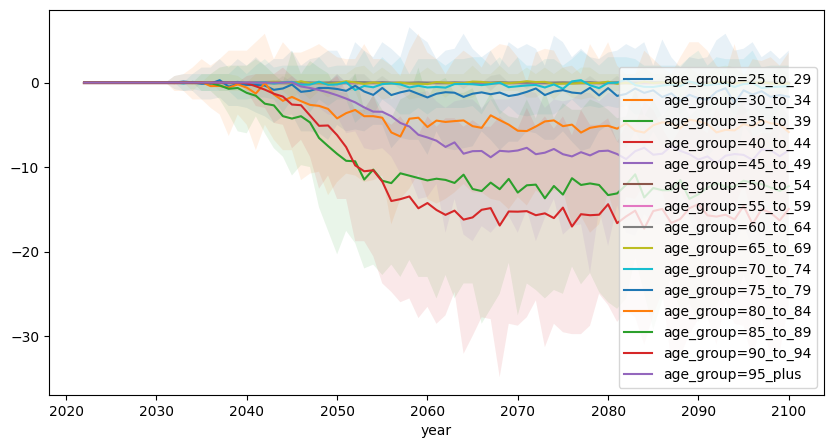

In [144]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


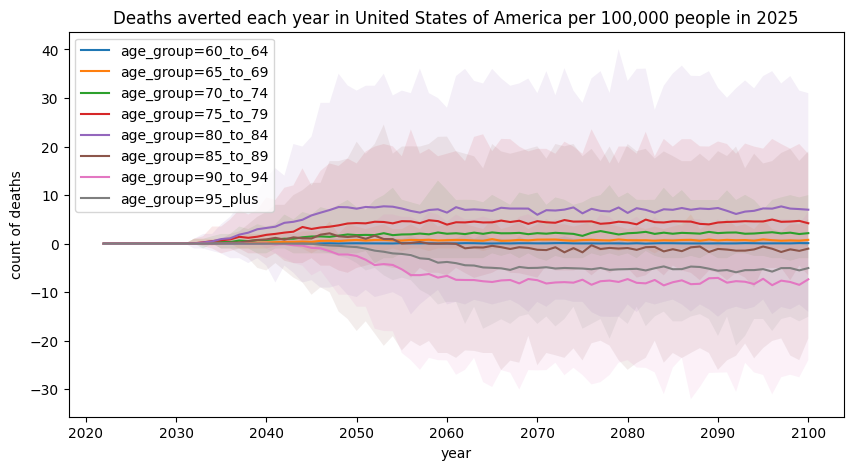

In [145]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

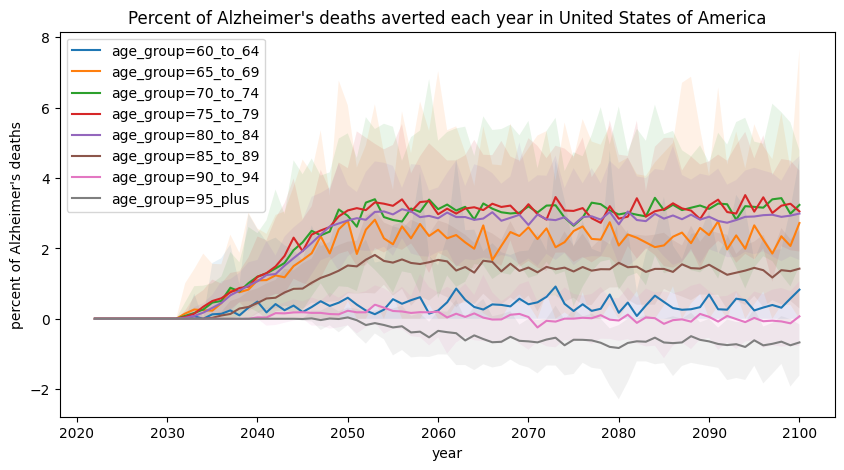

In [146]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [147]:
deaths.scenario.unique()

['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

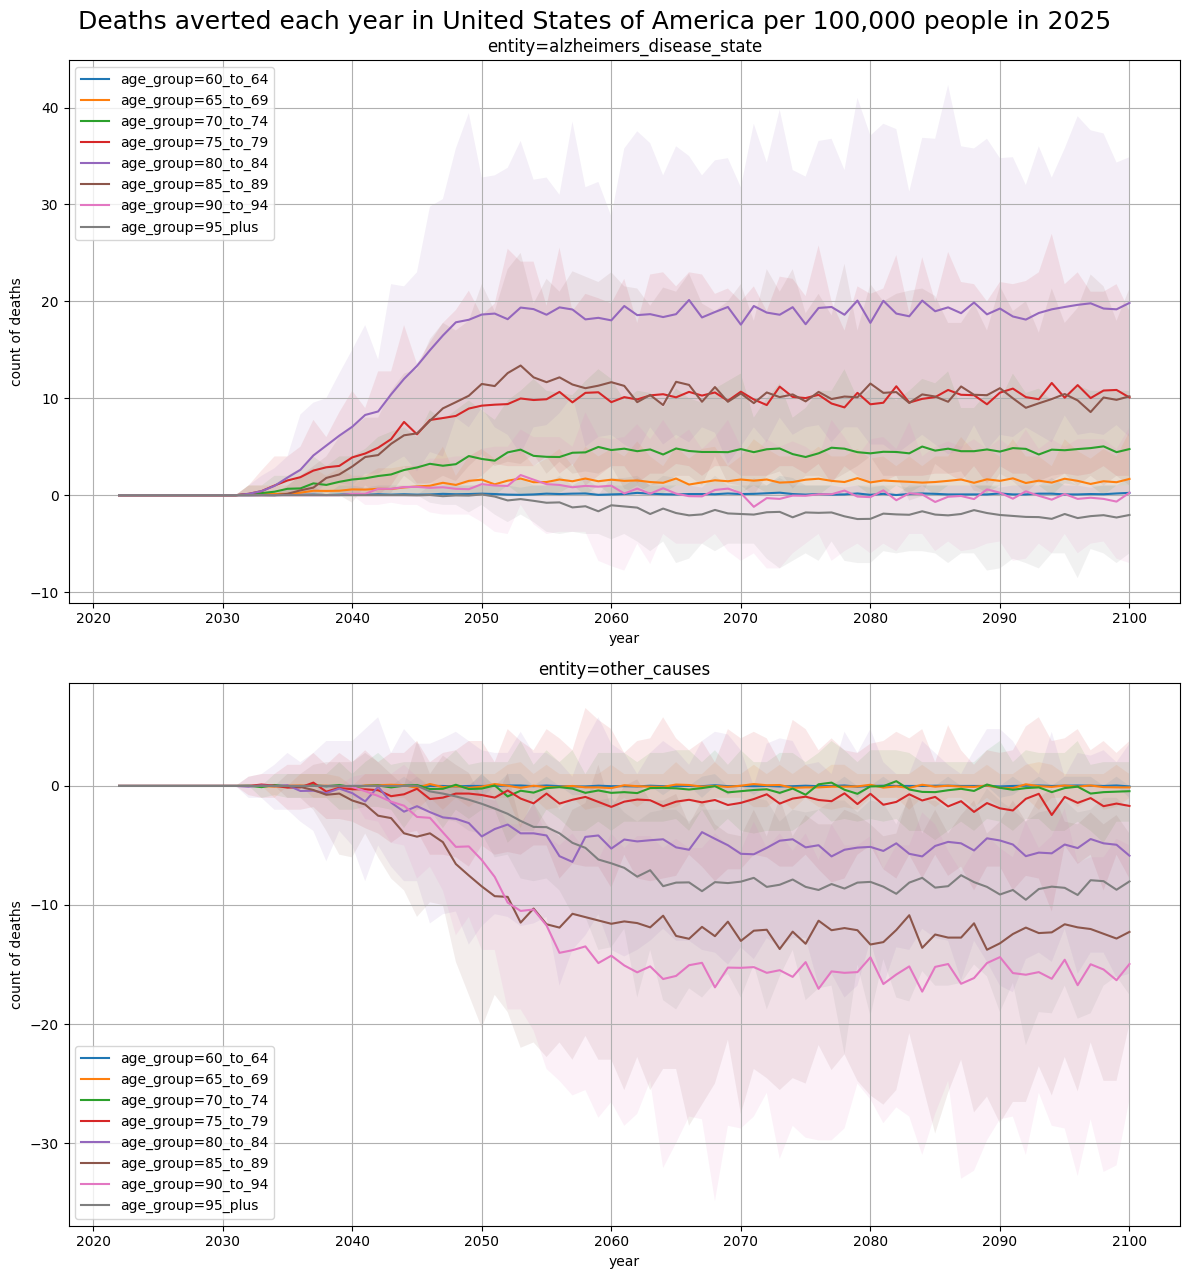

In [148]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

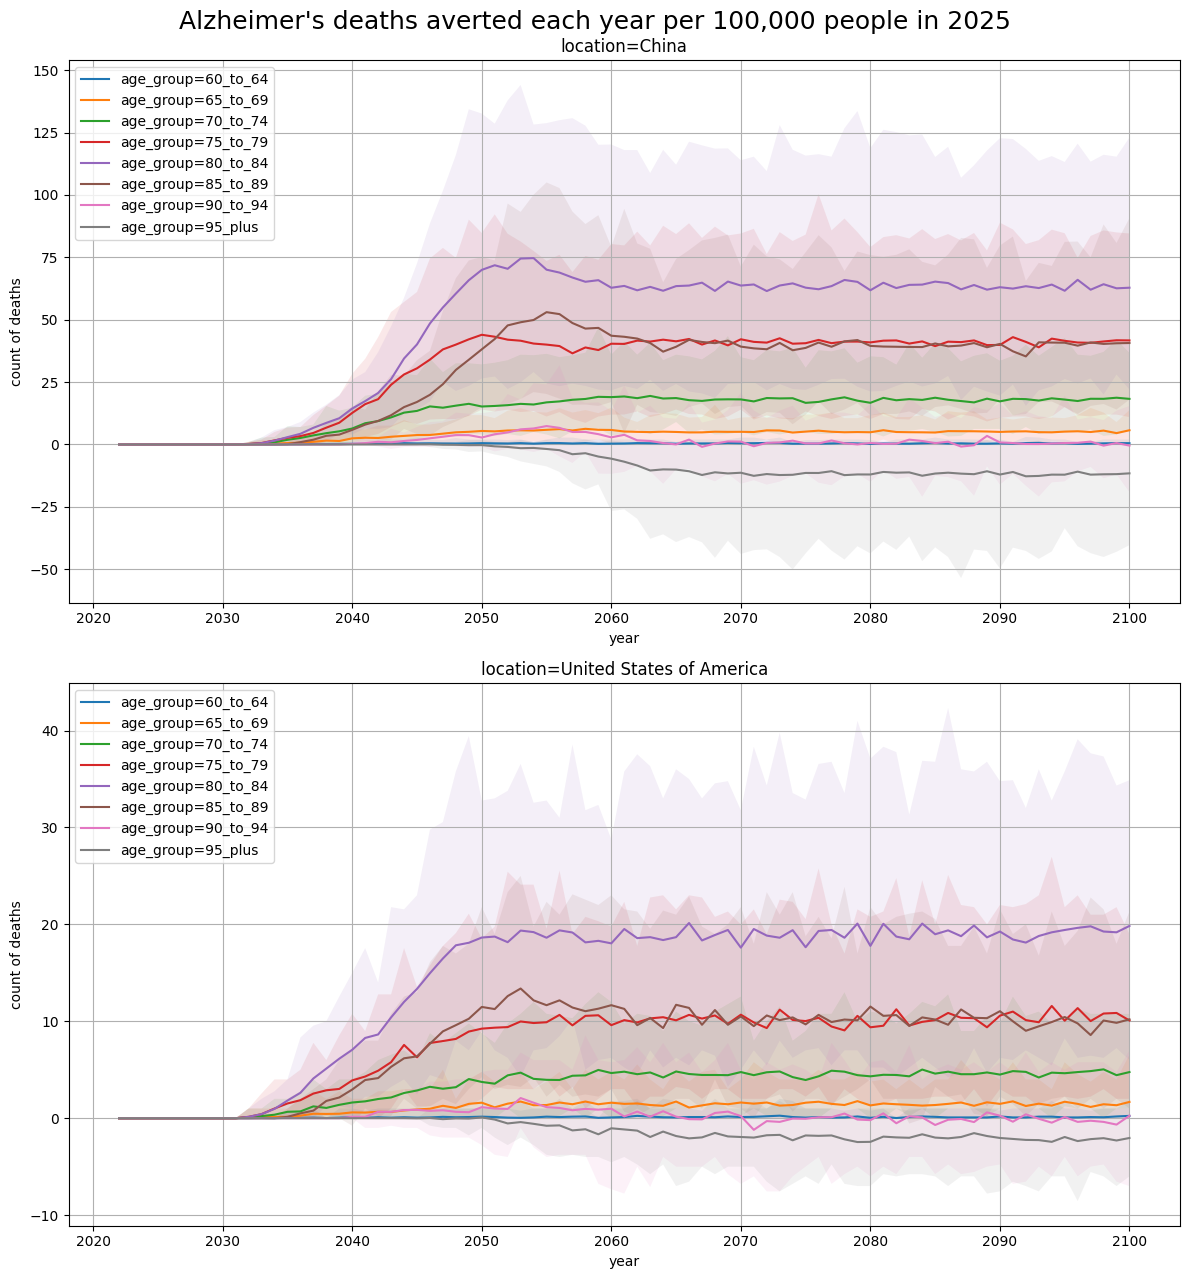

In [149]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

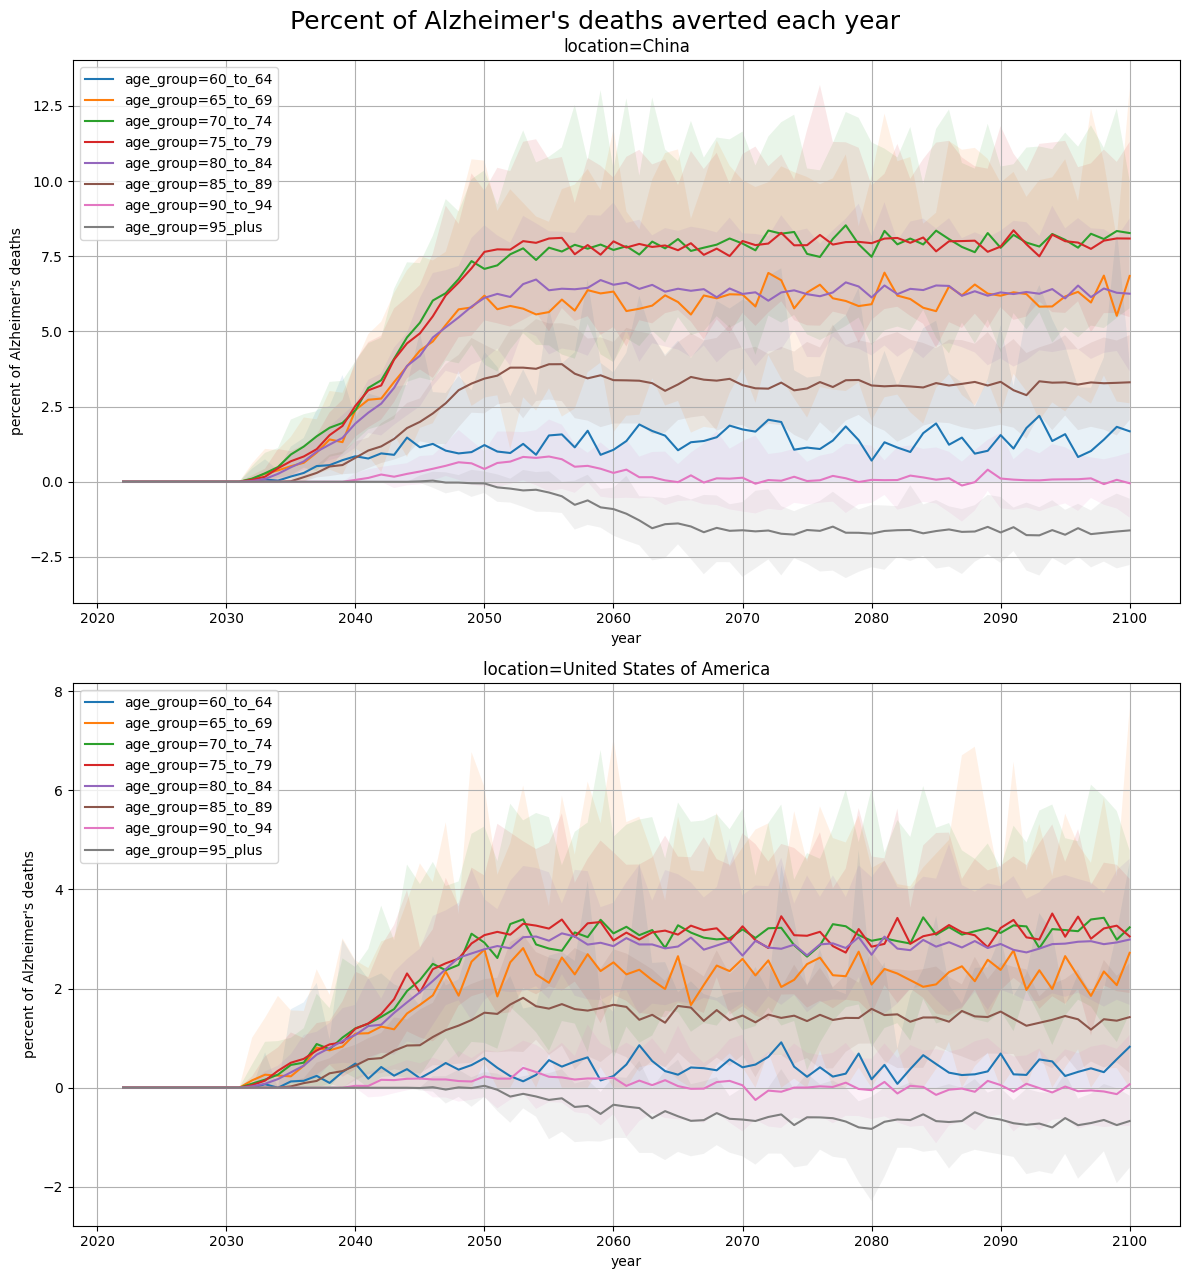

In [150]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [151]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


9.01025 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236    ylls   
1       alzheimers_disease_state       cause        2022        236    ylls   
2       alzheimers_disease_state       cause        2022        236    ylls   
3       alzheimers_disease_state       cause        2022        236    ylls   
4       alzheimers_disease_state       cause        2022        183    ylls   
...                          ...         ...         ...        ...     ...   
473995              other_causes       cause        2100        248    ylls   
473996              other_causes       cause        2100         50    ylls   
473997              other_causes       cause        2100         50    ylls   
473998              other_causes       cause        2100         50    ylls   
473999              other_causes       cause        2100         50    ylls   

                          scenario     sex         value  \
0                         baseline  Female      0.000000   
1                         baseline    Male      0.000000   
2       bbbm_testing_and_treatment  Female      0.000000   
3       bbbm_testing_and_treatment    Male      0.000000   
4                         baseline  Female      0.000000   
...                            ...     ...           ...   
473995  bbbm_testing_and_treatment    Male   1520.423659   
473996                    baseline  Female  23507.820383   
473997                    baseline    Male   2412.911299   
473998  bbbm_testing_and_treatment  Female  24049.152440   
473999  bbbm_testing_and_treatment    Male   2536.283380   

                        location  
0       United States of America  
1       United States of America  
2       United States of America  
3       United States of America  
4       United States of America  
...                          ...  
473995                     China  
473996                     China  
473997                     China  
473998                     China  
473999                     China  

[474000 rows x 11 columns]

In [152]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

9.01025 MB measure
6.403118 MB minuend
6.403118 MB subtrahend
4.273422 MB minuend re-indexed
4.273422 MB subtrahend re-indexed
4.273482 MB difference
5.92925 MB difference with reset index
6.166575 MB final difference
6.166575 MB


In [153]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

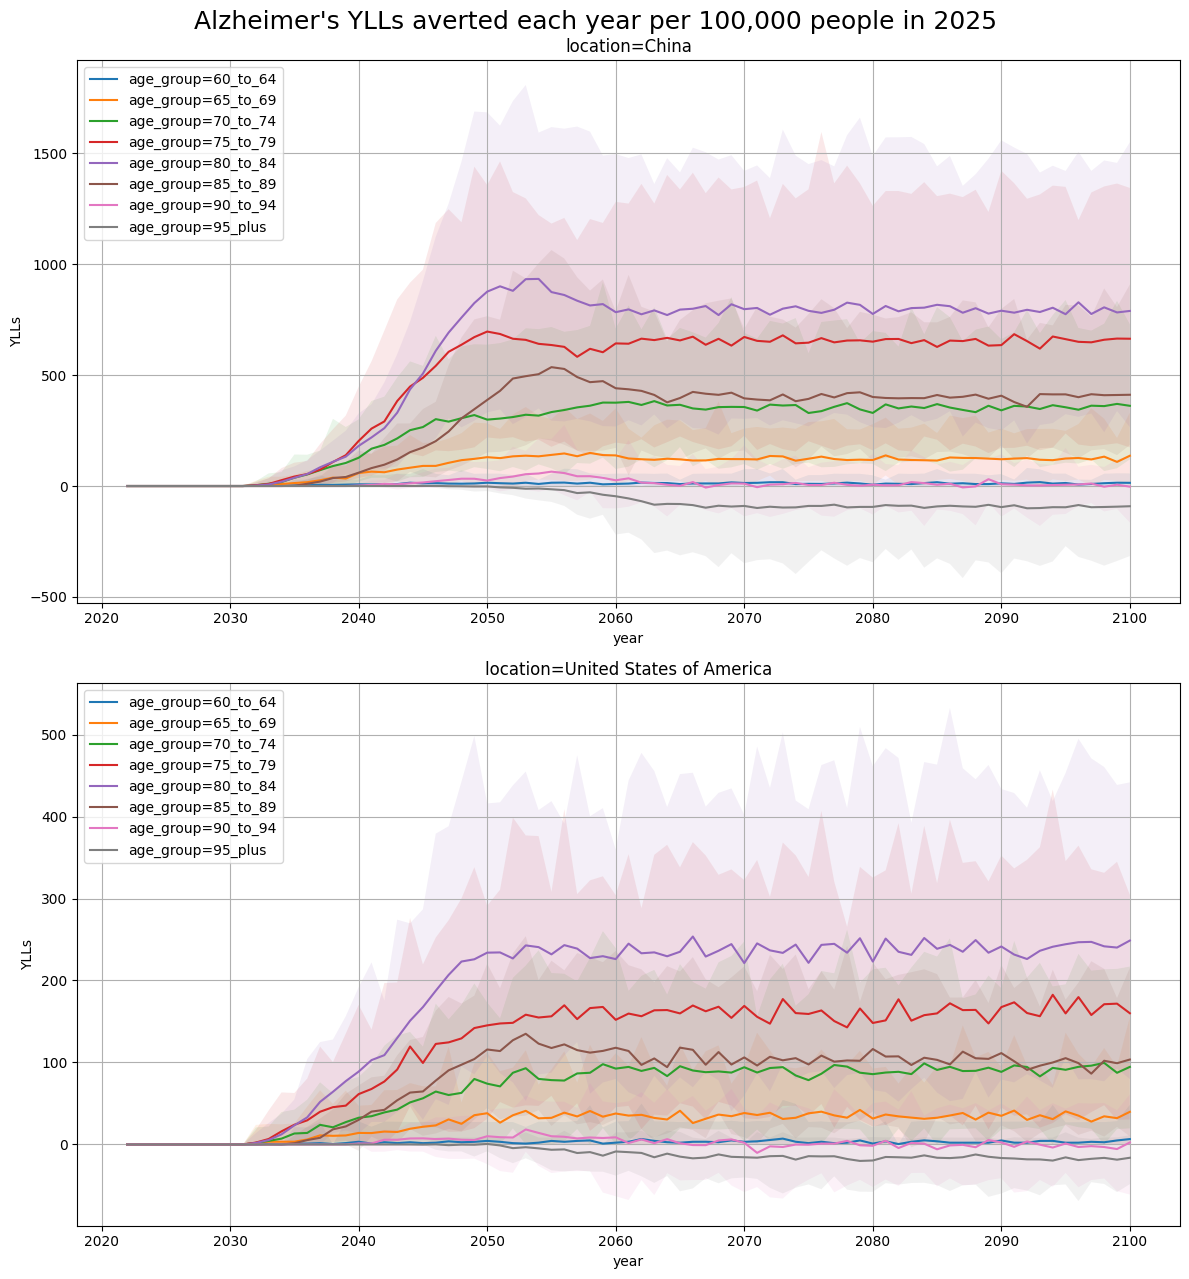

In [154]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

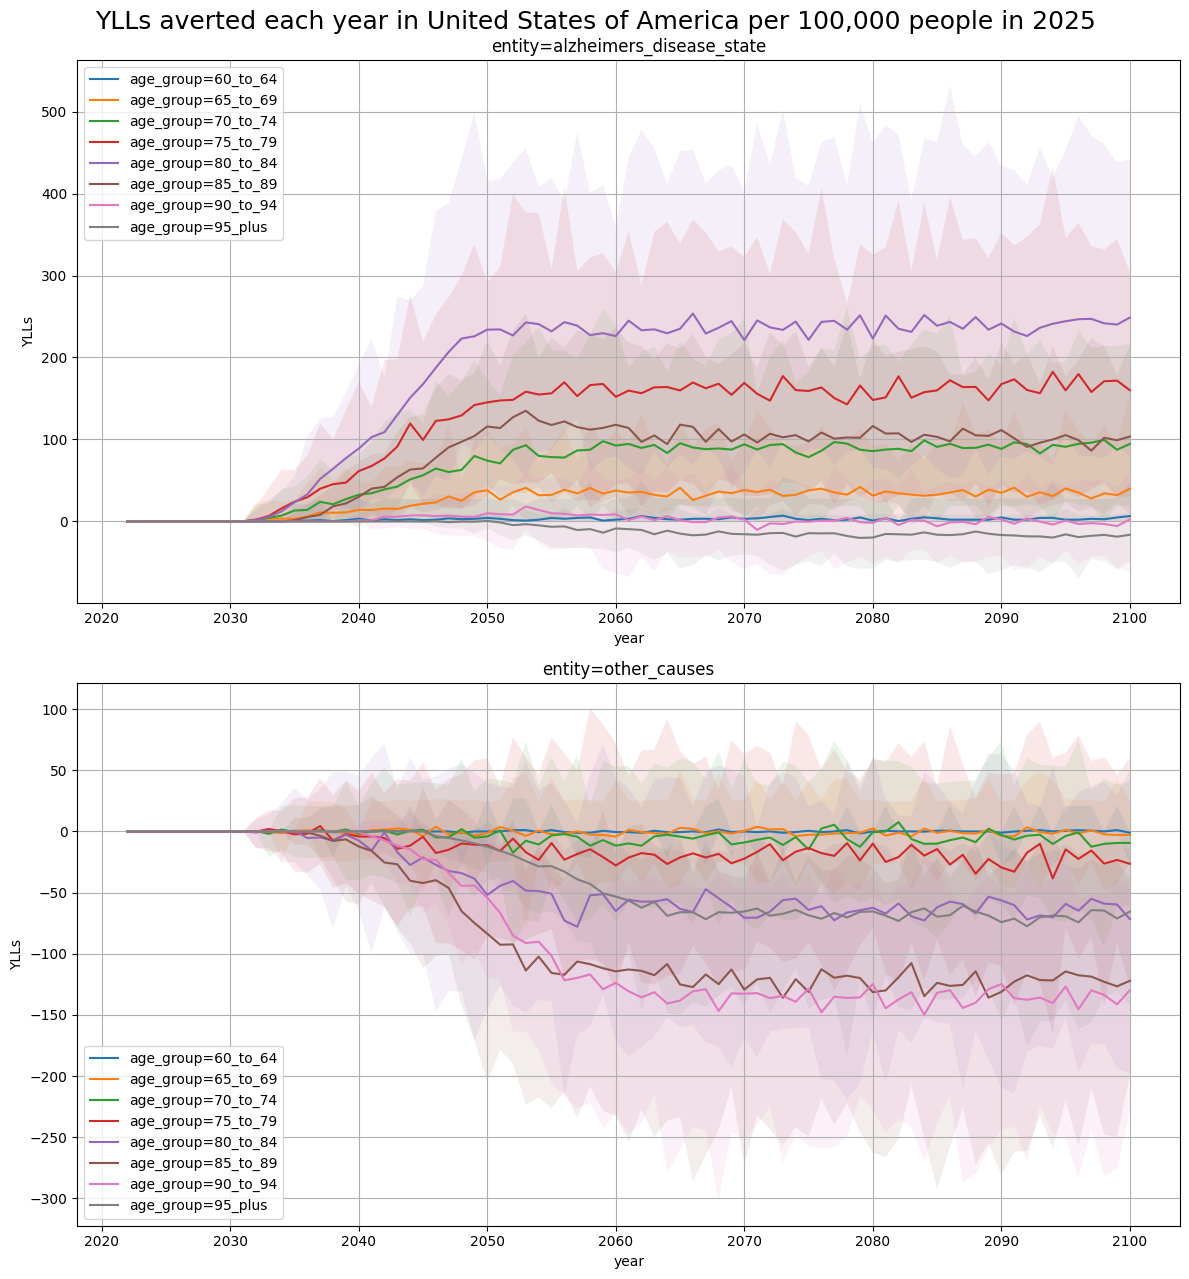

In [155]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

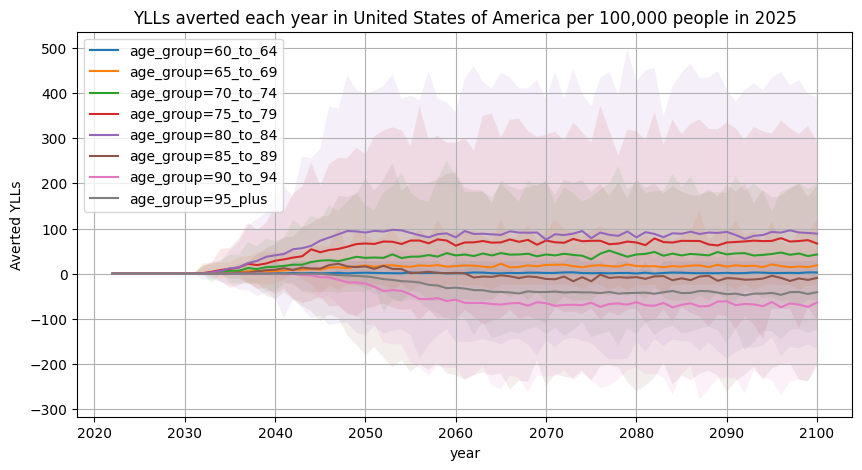

In [156]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [157]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
56.885581 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2843995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
2843995                              all_causes       cause        2100   
2843996                              all_causes       cause        2100   
2843997                              all_causes       cause        2100   
2843998                              all_causes       cause        2100   
2843999                              all_causes       cause        2100   

        input_draw measure                    scenario     sex  \
0              236    ylds                    baseline  Female   
1              236    ylds                    baseline  Female   
2              236    ylds                    baseline  Female   
3              236    ylds                    baseline    Male   
4              236    ylds                    baseline    Male   
...            ...     ...                         ...     ...   
2843995        248    ylds  bbbm_testing_and_treatment    Male   
2843996         50    ylds                    baseline  Female   
2843997         50    ylds                    baseline    Male   
2843998         50    ylds  bbbm_testing_and_treatment  Female   
2843999         50    ylds  bbbm_testing_and_treatment    Male   

                                         sub_entity        value  \
0            alzheimers_blood_based_biomarker_state     0.000000   
1        alzheimers_mild_cognitive_impairment_state     0.000000   
2                          alzheimers_disease_state     0.000000   
3            alzheimers_blood_based_biomarker_state     0.000000   
4        alzheimers_mild_cognitive_impairment_state     0.000000   
...                                             ...          ...   
2843995                                  all_causes    65.081936   
2843996                                  all_causes  3819.882884   
2843997                                  all_causes   177.969554   
2843998                                  all_causes  3881.717149   
2843999                                  all_causes   185.272968   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
2843995                     China  
2843996                     China  
2843997                     China  
2843998                     China  
2843999                     China  

[2844000 rows x 12 columns]

In [158]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

56.885581 MB measure
39.821449 MB minuend
39.821449 MB subtrahend
27.026825 MB minuend re-indexed
27.026825 MB subtrahend re-indexed
27.026885 MB difference
36.977581 MB difference with reset index
38.399906 MB final difference
38.399906 MB
29.867906 MB


In [159]:
1086.443257 / 27.372526

39.69101196579373

In [160]:
averted_ylds.memory_usage(deep=True)

Index                   132
age_group           1423530
artifact_path       1422427
entity              1422336
entity_type         1422170
event_year          2844000
input_draw          1422756
measure             1422169
sex                 1422232
sub_entity          1423253
location            1422251
scenario            1422325
subtracted_from     1422325
value              11376000
dtype: int64

In [161]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw         category
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [162]:
averted_ylds

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1421995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
1421995                              all_causes       cause        2100   
1421996                              all_causes       cause        2100   
1421997                              all_causes       cause        2100   
1421998                              all_causes       cause        2100   
1421999                              all_causes       cause        2100   

        input_draw measure     sex  \
0              236    ylds  Female   
1              236    ylds  Female   
2              236    ylds  Female   
3              236    ylds    Male   
4              236    ylds    Male   
...            ...     ...     ...   
1421995        219    ylds    Male   
1421996        248    ylds  Female   
1421997        248    ylds    Male   
1421998         50    ylds  Female   
1421999         50    ylds    Male   

                                         sub_entity                  location  \
0            alzheimers_blood_based_biomarker_state  United States of America   
1        alzheimers_mild_cognitive_impairment_state  United States of America   
2                          alzheimers_disease_state  United States of America   
3            alzheimers_blood_based_biomarker_state  United States of America   
4        alzheimers_mild_cognitive_impairment_state  United States of America   
...                                             ...                       ...   
1421995                                  all_causes                     China   
1421996                                  all_causes                     China   
1421997                                  all_causes                     China   
1421998                                  all_causes                     China   
1421999                                  all_causes                     China   

                           scenario subtracted_from      value  
0        bbbm_testing_and_treatment        baseline   0.000000  
1        bbbm_testing_and_treatment        baseline   0.000000  
2        bbbm_testing_and_treatment        baseline   0.000000  
3        bbbm_testing_and_treatment        baseline   0.000000  
4        bbbm_testing_and_treatment        baseline   0.000000  
...                             ...             ...        ...  
1421995  bbbm_testing_and_treatment        baseline  -2.790917  
1421996  bbbm_testing_and_treatment        baseline -10.153645  
1421997  bbbm_testing_and_treatment        baseline  -2.189195  
1421998  bbbm_testing_and_treatment        baseline -61.834264  
1421999  bbbm_testing_and_treatment        baseline  -7.303414  

[1422000 rows x 13 columns]

In [163]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [164]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
11850    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11851    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11852    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11853    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11854    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1418045   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1418046   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1418047   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1418048   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1418049   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw measure     sex  \
11850    treatment       cause        2022        236    ylds  Female   
11851    treatment       cause        2022        236    ylds  Female   
11852    treatment       cause        2022        236    ylds  Female   
11853    treatment       cause        2022        236    ylds  Female   
11854    treatment       cause        2022        236    ylds  Female   
...            ...         ...         ...        ...     ...     ...   
1418045  treatment       cause        2100         50    ylds    Male   
1418046  treatment       cause        2100         50    ylds    Male   
1418047  treatment       cause        2100         50    ylds    Male   
1418048  treatment       cause        2100         50    ylds    Male   
1418049  treatment       cause        2100         50    ylds    Male   

                      sub_entity                  location  \
11850      waiting_for_treatment  United States of America   
11851           full_effect_long  United States of America   
11852          full_effect_short  United States of America   
11853         waning_effect_long  United States of America   
11854        waning_effect_short  United States of America   
...                          ...                       ...   
1418045       waning_effect_long                     China   
1418046      waning_effect_short                     China   
1418047     no_effect_after_long                     China   
1418048    no_effect_after_short                     China   
1418049  no_effect_never_treated                     China   

                           scenario subtracted_from  value  
11850    bbbm_testing_and_treatment        baseline    0.0  
11851    bbbm_testing_and_treatment        baseline    0.0  
11852    bbbm_testing_and_treatment        baseline    0.0  
11853    bbbm_testing_and_treatment        baseline    0.0  
11854    bbbm_testing_and_treatment        baseline    0.0  
...                             ...             ...    ...  
1418045  bbbm_testing_and_treatment        baseline    0.0  
1418046  bbbm_testing_and_treatment        baseline    0.0  
1418047  bbbm_testing_and_treatment        baseline    0.0  
1418048  bbbm_testing_and_treatment        baseline    0.0  
1418049  bbbm_testing_and_treatment        baseline    0.0  

[948000 rows x 13 columns]

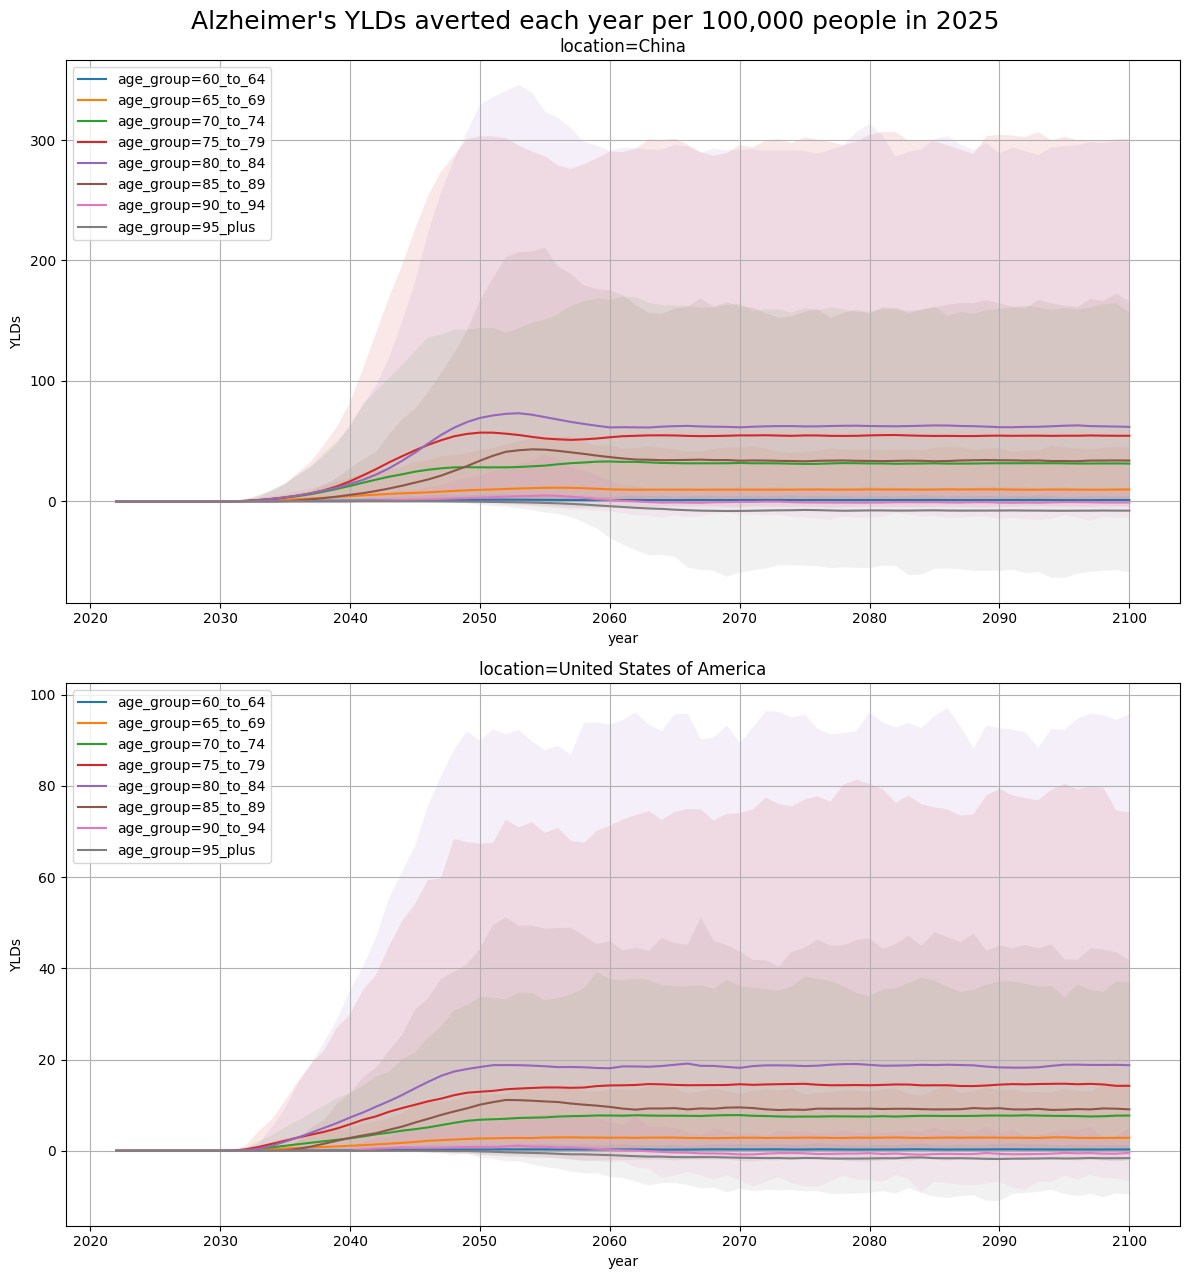

In [165]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

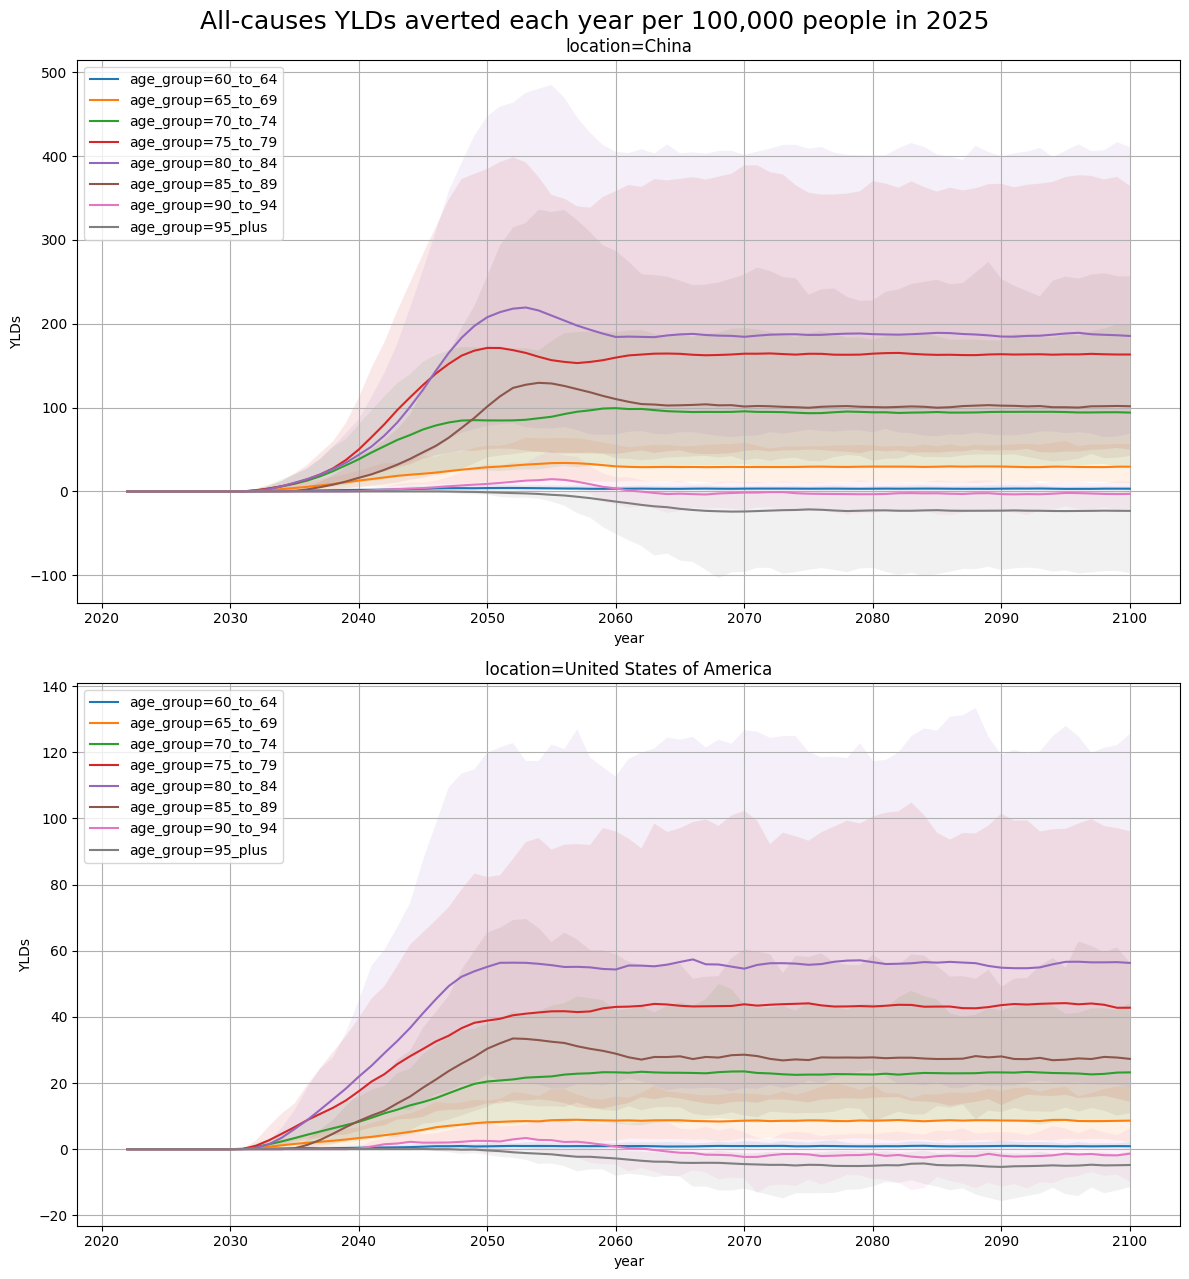

In [166]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [167]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2026-01-13 02:02:33.471280
